In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cv2

In [2]:
########## Camera Caliberation ##########
imagesFilepath = glob.glob('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
imageFilepath = imagesFilepath[0]

In [3]:
########### function to undistort the image ########
####### Using the chess board images for further caliberation ##############
##### Using the chessboard images to derive the matrix ############
def cal_undistort(img, objectpoints, imagepoints, others = False):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #undist = np.copy(img)  # Delete this line
    img_size = img.shape[0:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, img_size,None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if others:
        return mtx,dist
    else:
        return undist
    



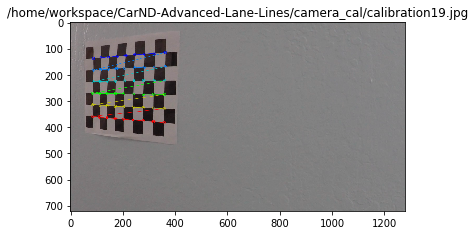

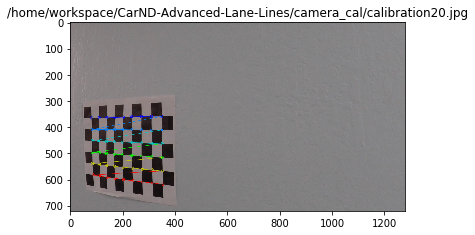

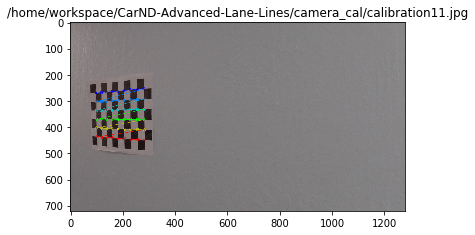

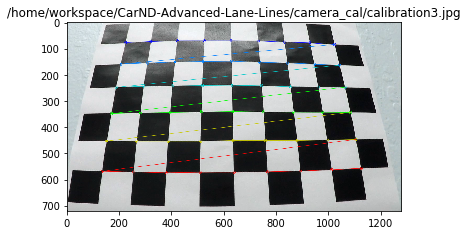

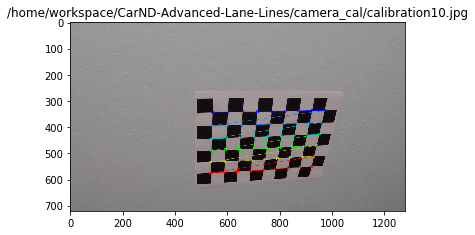

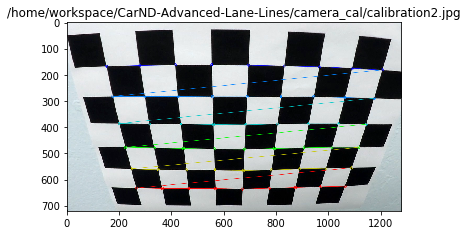

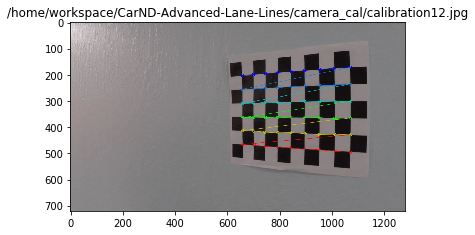

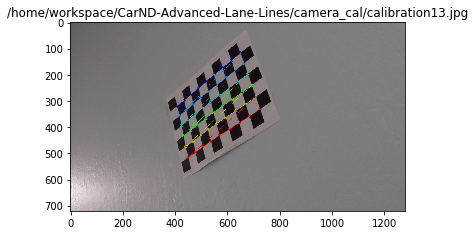

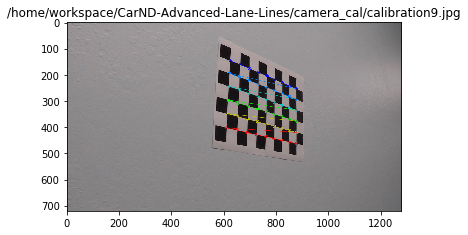

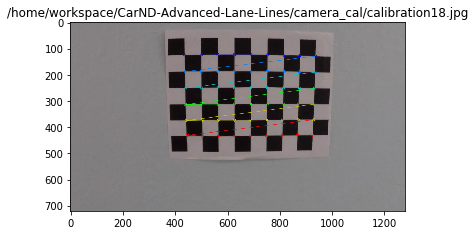

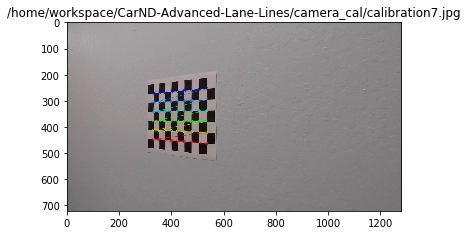

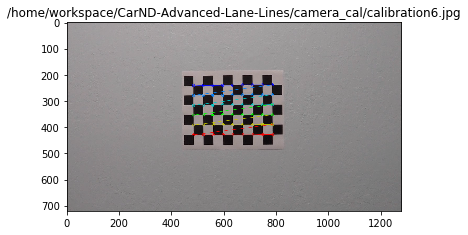

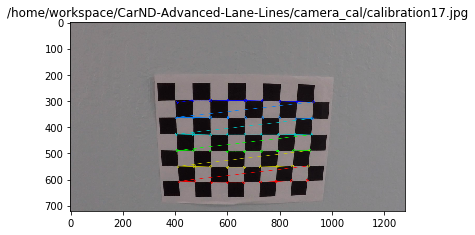

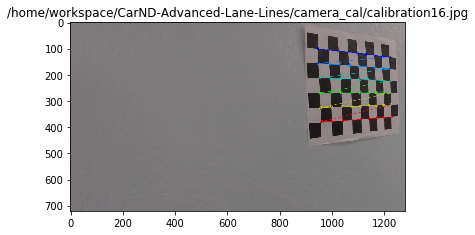

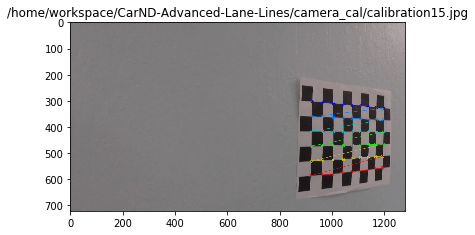

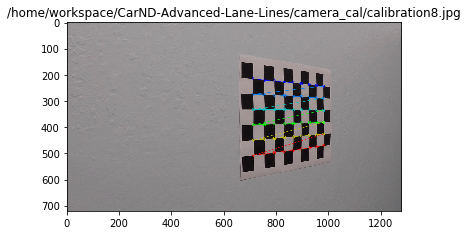

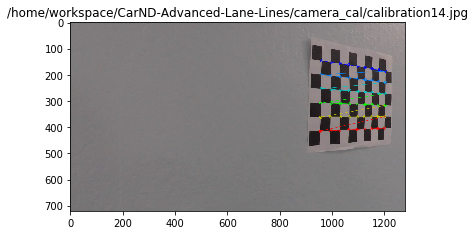

In [4]:
########### Finding out the object points and image points when corners are detected ###########

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
#objp = np.array([objp])
objpoints = []
imgpoints = []
undistorted = []
orgImage  = []
nx = 9 # enter the number of inside corners in x
ny = 6 # enter the number of inside corners in y
i= 1
for imageFilepath in imagesFilepath:
    img = cv2.imread(imageFilepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        #corners = np.array([[corner for [corner] in corners]])
        objpoints.append(objp)
        imgpoints.append(corners)
        orgImage.append(img)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.figure(i)
        plt.title('{}'.format(imageFilepath))
        plt.imshow(img)
        i+=1
    

In [5]:
############## Example of undistorting a chess image ###########
test_img='camera_cal/calibration1.jpg'
orgImg = []
undistorted = []
for imageFilepath in imagesFilepath:
    img = cv2.imread(imageFilepath)
    undistorted.append(cal_undistort(img, objpoints, imgpoints))
    orgImg.append(img)

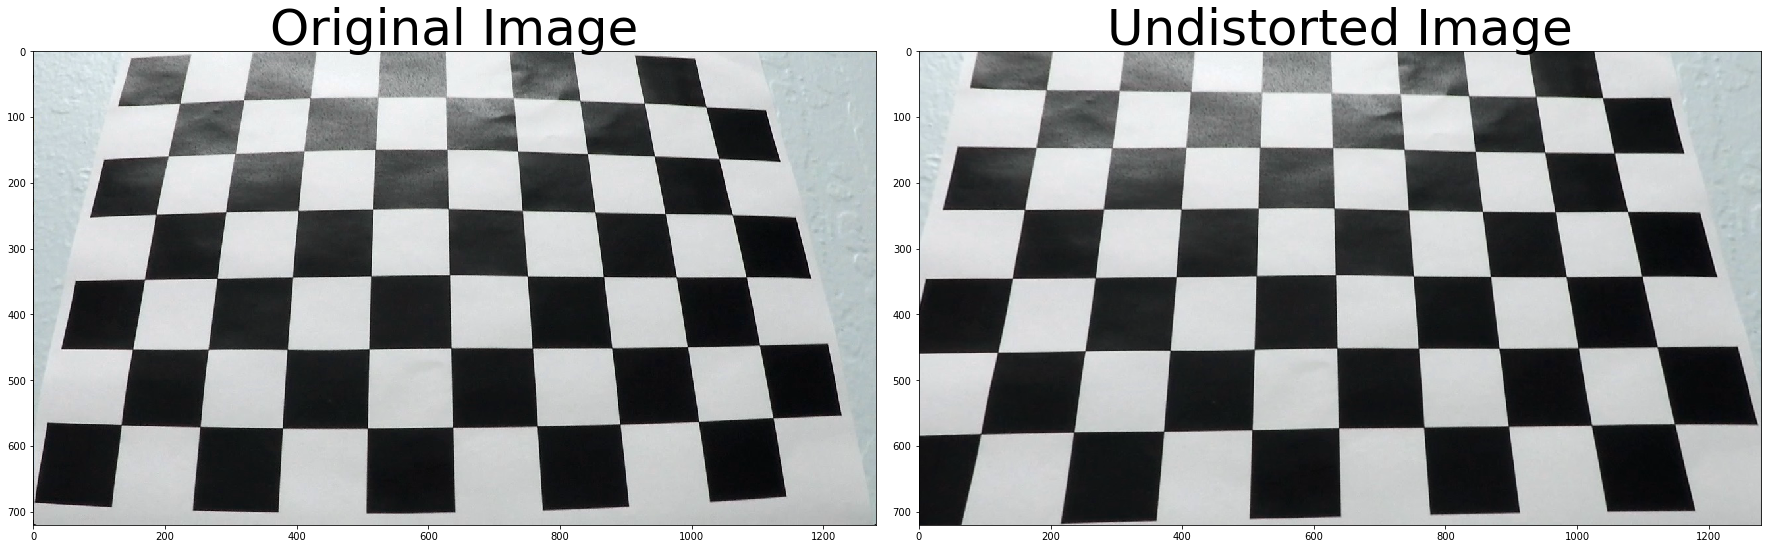

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orgImg[5])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted[5])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
filepath = os.path.join('/home/workspace/CarND-Advanced-Lane-Lines/output_images/undistorted_chessboard.jpg')
cv2.imwrite(filepath,undistorted[5])

True

In [8]:
testImagepath = glob.glob('/home/workspace/CarND-Advanced-Lane-Lines/test_images/test*.jpg')


In [9]:
orgImg = []
undistorted = []
for imageFilepath in testImagepath:
    img = cv2.imread(imageFilepath)
    undistorted.append(cal_undistort(img, objpoints, imgpoints))
    orgImg.append(img)

mtx, dist = cal_undistort(img,objpoints,imgpoints,others = True)    

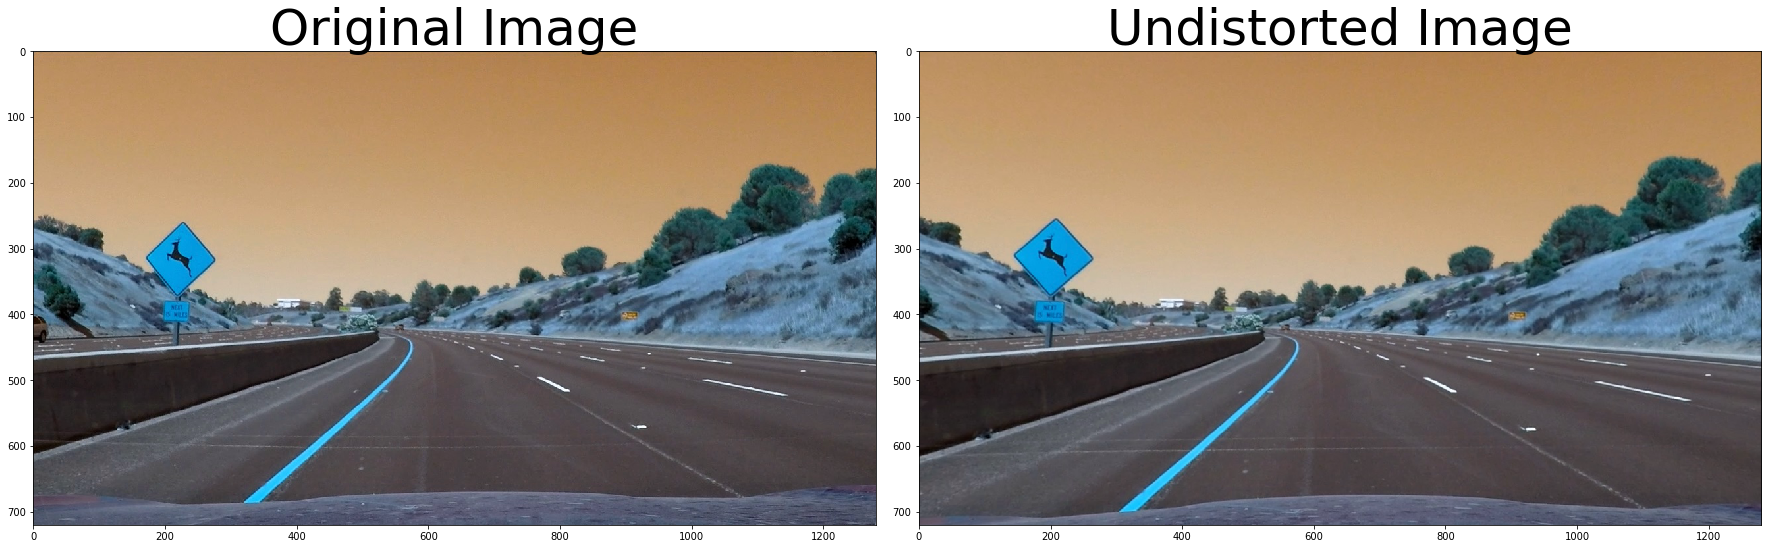

In [10]:
######### Example of undistorting an image from the call_undistort function ############
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orgImg[5])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted[5])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
filepath = os.path.join('/home/workspace/CarND-Advanced-Lane-Lines/output_images/undistorted_testImage.jpg')
cv2.imwrite(filepath,undistorted[5])

True

In [12]:
######## Function for retreiving a binary thresholded image ##########
def binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100),l_thresh = (225,255),b_thresh = (155,200)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)   ###### Converting RGB to HLS color format
    s_channel = hls[:,:,2]   ###### Consdiering only the Saturation channel, as opposed to Lightness

    # Grayscale image
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    luv = cv2.cvtColor(img,cv2.COLOR_RGB2Luv)
    lab = cv2.cvtColor(img,cv2.COLOR_RGB2Lab) 
    
    
    l_channel = luv[:,:,0]
    b_channel = lab[:,:,2]
    
    # Sobel x Finding gradients along X and Y directions. 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) # Converting into unsigned interger format
    sxbinary = np.zeros_like(scaled_sobel)
    # Applying appropriate thresholding make all pixels between the low and high threshold values as 1 
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1 
    
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    # Combine the two binary thresholds
    #### Combining binary images from sobel_x filter and s_channel images 
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(b_binary == 1) | (l_binary == 1) | (s_binary == 1) | (sxbinary == 1)] = 1

    
    
    return combined_binary

In [13]:
binary = []
for i in range(len(undistorted)):
    binary.append(binary_image(undistorted[i]))

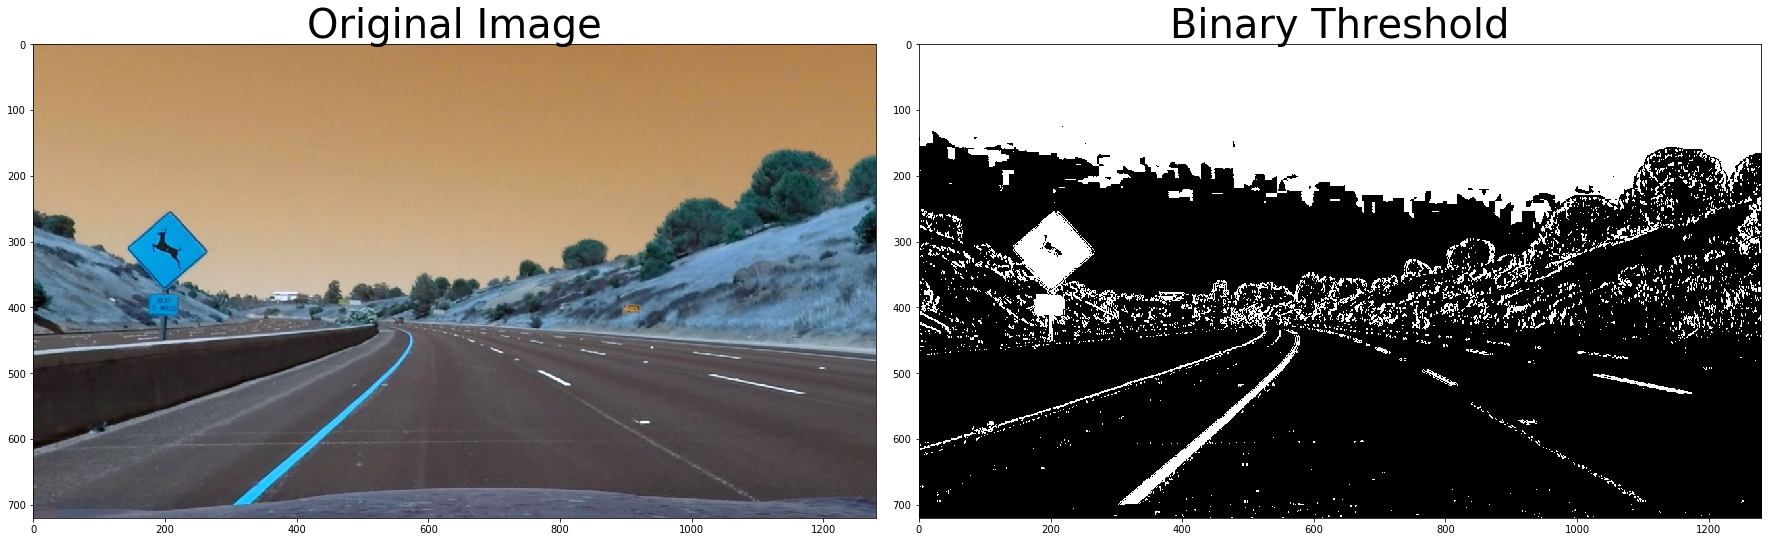

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted[5],cmap = 'gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary[5], cmap = 'gray')
ax2.set_title('Binary Threshold', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
filepath = os.path.join('/home/workspace/CarND-Advanced-Lane-Lines/output_images/binary_testImage.jpg')
plt.savefig(filepath)

In [15]:
############# Function for creating perspective transformed image #############
def return_warped_image(img,x_adj=0):
    
   
    img_height = img.shape[0]
    img_width = img.shape[1]
    imshape = (img_height, img_width)
    xcenter=imshape[1]/2+x_adj
    xfd=50
    yf=450
    offset=100
    ######## Calculating source and destination points ##########
    ###### Based on the test images an offset of 100 is provided ###########
    src = np.float32(
        [(offset,imshape[0]),
         (xcenter-xfd, yf), 
         (xcenter+xfd,yf), 
         (imshape[1]-offset,imshape[0])])
    
    dst = np.float32(
        [(offset,imshape[1]),
         (offset,0),
         (imshape[0]-offset, 0),
        (imshape[0]-offset,imshape[1])])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, imshape, flags=cv2.INTER_LINEAR)
    
    mid_point = warped.shape[1]/2
    first = np.argmax(np.sum(warped[:,0:int(mid_point)],axis = 0))
    second = np.argmax(np.sum(warped[:,int(mid_point):],axis = 0))
    distance = (int(mid_point)+second)-first
    #print('distance:{}'.format(distance))
    return warped, M , Minv

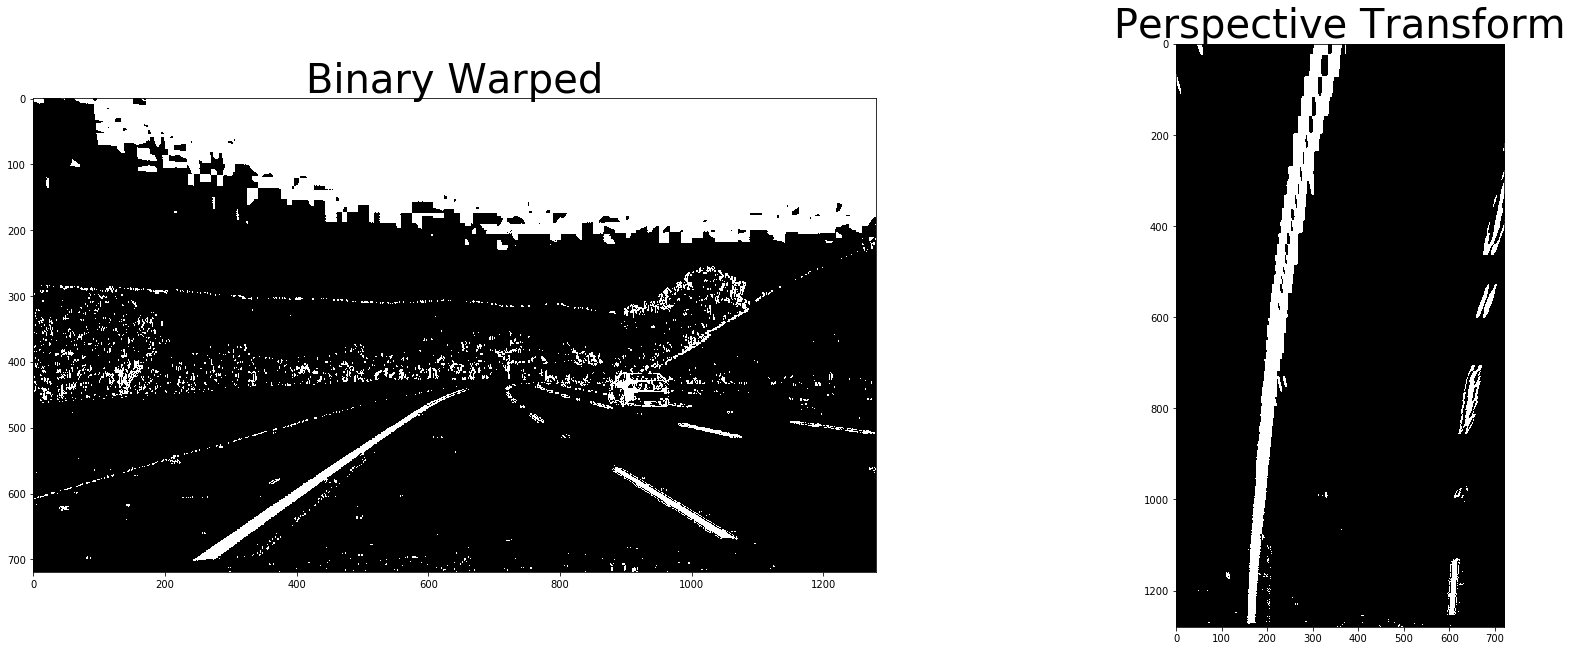

In [16]:
warped = []
for i in range(len(binary)):
    res,_,_ = return_warped_image(binary[i])
    warped.append(res)
    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary[3],cmap = 'gray')
ax1.set_title('Binary Warped', fontsize=40)

ax2.imshow(warped[3], cmap = 'gray')
ax2.set_title('Perspective Transform', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
filepath = os.path.join('/home/workspace/CarND-Advanced-Lane-Lines/output_images/perspective_testImage.jpg')
plt.savefig(filepath)

In [17]:
'''img = warped[3][640:,]
plt.imshow(img, cmap = 'gray')
plt.figure(2)
#plt.plot(np.sum(img, axis = 0))
mid_point = img.shape[1]/2
first = np.argmax(np.sum(img[:,0:int(mid_point)],axis = 0))
second = np.argmax(np.sum(img[:,int(mid_point):],axis = 0))'''

"img = warped[3][640:,]\nplt.imshow(img, cmap = 'gray')\nplt.figure(2)\n#plt.plot(np.sum(img, axis = 0))\nmid_point = img.shape[1]/2\nfirst = np.argmax(np.sum(img[:,0:int(mid_point)],axis = 0))\nsecond = np.argmax(np.sum(img[:,int(mid_point):],axis = 0))"

In [18]:
############ Functions to finding lane pixels and fitting a second order polynomial to it ##############
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #histogram = np.sum(binary_warped[900:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx,right_fitx,ploty

########## plotting the detected polynomial fits onto the actual image ############

def plot_detected_orig_image(off_str,curv_str, img,undist,perspectiveTransformImage,Minv,left_fitx,right_fitx,ploty):
    warp_zero = np.zeros_like(perspectiveTransformImage).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.putText(result,curv_str , (200, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result,off_str , (200, 130), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    distance = round(np.abs(left_fitx[0]-right_fitx[0]),2)
    dis_str = "distance:{} pixels".format(distance)
    cv2.putText(result,dis_str , (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result



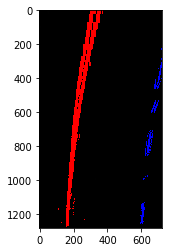

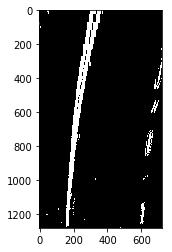

In [19]:
out_img,left_fitx,right_fitx,ploty = fit_polynomial(warped[3])
plt.figure(1)
plt.imshow(out_img,cmap = 'gray')
#filepath = os.path.join('/home/workspace/CarND-Advanced-Lane-Lines/output_images/fitted_polynomial_testImage.jpg')
#plt.savefig(filepath)
plt.figure(2)
plt.imshow(warped[3],cmap = 'gray')


In [20]:
####### Function to calculate the actual radius of curvature  in meters#############
def measure_curvature_real(xvals,num_rows):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit = np.polyfit(y_points*ym_per_pix, xvals*xm_per_pix, 2)
    curverad = ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    

    return curverad


def measure_curvature_realAlt(ploty,vals):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    fit = np.polyfit(ploty*ym_per_pix, vals*xm_per_pix, 2)
    y_eval = np.max(ploty)
    curverad = ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    return curverad


def measure_offset(left_fitx,right_fitx,num_rows,sizeOfImg):
    #pdb.set_trace()
    lane_center = (right_fitx[num_rows-1] + left_fitx[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset_px= abs(sizeOfImg/2 - lane_center)
    offset_m = xm_per_pix*offset_px
    return offset_m
    

In [29]:
######## Building pipeline ########
global left_fitxlist
global right_fitxlist
left_fitxlist = []
right_fitxlist = []
import pdb
def complete_pipeline(img):

    global prev_leftx
    global prev_rightx
    global prev_ploty
    

    
    img_size = (img.shape[1], img.shape[0])
    #img = cv2.imread(testImagepath[0])
    #undist = cal_undistort(img, objpoints, imgpoints)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binaryImage = binary_image(undist)
    perspectiveTransformImage,M,Minv = return_warped_image(binaryImage)
    fitPolynomial,left_fitx,right_fitx,ploty = fit_polynomial(perspectiveTransformImage)
    

    
    
    #left_curvature= round(measure_curvature_real(left_fitx,perspectiveTransformImage.shape[0]),2)
    #right_curvature  = round(measure_curvature_real(right_fitx,perspectiveTransformImage.shape[0]),2)
    
    left_curvature= round(measure_curvature_realAlt(ploty,left_fitx),2)
    right_curvature  = round(measure_curvature_realAlt(ploty,right_fitx),2)
    print(left_fitx)
    
    curv = (left_curvature+right_curvature)/2
    curvature = "left Rad: {} m , Right Rad: {} m".format(left_curvature,right_curvature)
    print(curvature)
    offset = measure_offset(left_fitx,right_fitx,perspectiveTransformImage.shape[0],img_size[0])
    offset = offset - 1
    off = "Offset: %.2f m" % offset
    distance = np.abs(left_fitx-right_fitx)
    if (min(distance)>300 and max(distance)<600):
        result= plot_detected_orig_image(off,curvature,img,undist,perspectiveTransformImage,Minv,left_fitx,right_fitx,ploty)
        #prev_leftx = left_fitx
        #prev_rightx = right_fitx
        left_fitxlist.append(left_fitx)
        right_fitxlist.append(right_fitx)
        try:
            prev_leftx = (left_fitxlist[-1]+left_fitxlist[-2]+left_fitxlist[-3]+left_fitxlist[-4])/4
            prev_rightx = (right_fitxlist[-1]+right_fitxlist[-2]+right_fitxlist[-3]+right_fitxlist[-4])/4
            prev_ploty = ploty
        except:
            prev_leftx = left_fitxlist[-1]
            prev_rightx = right_fitxlist[-1]
            prev_ploty = ploty
            
        #avg_leftx = 
    else:
        #pdb.set_trace()
        result= plot_detected_orig_image(off,curvature,img,undist,perspectiveTransformImage,Minv,prev_leftx,prev_rightx,prev_ploty)

        


    
    return result

[ 333.31890719  333.08767531  332.85660336 ...,  168.33798707  168.3109906
  168.28415407]
left Rad: 2053.72 m , Right Rad: 2668.28 m


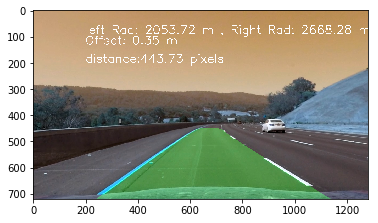

In [30]:
img = cv2.imread(testImagepath[3])
result= complete_pipeline(img)
plt.imshow(result)
filepath = os.path.join('/home/workspace/CarND-Advanced-Lane-Lines/output_images/FinalResult_withdetection.jpg')
plt.savefig(filepath)

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
white_output = '/home/workspace/CarND-Advanced-Lane-Lines/output_images/project_video_alternate.mp4'
#clip1 = VideoFileClip('/home/workspace/CarND-Advanced-Lane-Lines/project_video.mp4').subclip(41,42)
clip1 = VideoFileClip('/home/workspace/CarND-Advanced-Lane-Lines/project_video.mp4')
white_clip = clip1.fl_image(complete_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[ 286.87184757  286.94664283  287.02120756 ...,  194.57559436  194.35601691
  194.13620893]
left Rad: 1426.51 m , Right Rad: 2629.09 m
[MoviePy] >>>> Building video /home/workspace/CarND-Advanced-Lane-Lines/output_images/challenge_video_alternate.mp4
[MoviePy] Writing video /home/workspace/CarND-Advanced-Lane-Lines/output_images/challenge_video_alternate.mp4


  0%|          | 1/485 [00:00<01:50,  4.38it/s]

[ 286.87184757  286.94664283  287.02120756 ...,  194.57559436  194.35601691
  194.13620893]
left Rad: 1426.51 m , Right Rad: 2629.09 m


  0%|          | 2/485 [00:00<01:54,  4.21it/s]

[ 288.5044685   288.58985239  288.67498479 ...,  192.6453428   192.40957567
  192.17355704]
left Rad: 1307.8 m , Right Rad: 5631.79 m


  1%|          | 3/485 [00:00<01:54,  4.19it/s]

[ 316.26063045  316.2770164   316.29323043 ...,  197.1187572   196.91560282
  196.71227652]
left Rad: 1912.42 m , Right Rad: 14064.22 m


  1%|          | 4/485 [00:00<01:54,  4.21it/s]

[ 290.26803617  290.32942725  290.39060725 ...,  196.68846483  196.48030108
  196.27192624]
left Rad: 1557.66 m , Right Rad: 2308.17 m


  1%|          | 5/485 [00:01<01:53,  4.22it/s]

[ 314.2167391   314.23196074  314.24701656 ...,  198.55382524  198.35728991
  198.16058876]
left Rad: 1982.59 m , Right Rad: 2984.09 m


  1%|          | 6/485 [00:01<01:54,  4.18it/s]

[ 273.12683829  273.21732254  273.3075732  ...,  198.35826771  198.15044952
  197.94239773]
left Rad: 1407.54 m , Right Rad: 3826.39 m


  1%|▏         | 7/485 [00:01<01:53,  4.20it/s]

[ 256.05765499  256.22475916  256.39152295 ...,  192.13641417  191.86885805
  191.60096156]
left Rad: 966.65 m , Right Rad: 4416.77 m


  2%|▏         | 8/485 [00:01<01:53,  4.21it/s]

[ 281.33784782  281.44302693  281.54793556 ...,  195.29327083  195.05306076
  194.81258022]
left Rad: 1216.08 m , Right Rad: 1530.18 m


  2%|▏         | 9/485 [00:02<01:54,  4.18it/s]

[ 315.56535718  315.600033    315.63451098 ...,  198.65906562  198.44109674
  198.22293002]
left Rad: 1662.09 m , Right Rad: 1824.43 m


  2%|▏         | 10/485 [00:02<01:53,  4.17it/s]

[ 347.71278441  347.65260498  347.59234492 ...,  205.1734137   205.01027151
  204.8470487 ]
left Rad: 4076.28 m , Right Rad: 1411.76 m


  2%|▏         | 11/485 [00:02<01:53,  4.17it/s]

[ 266.68852728  266.84331829  266.99777563 ...,  192.51210872  192.24081112
  191.96917985]
left Rad: 986.14 m , Right Rad: 2132.63 m


  2%|▏         | 12/485 [00:02<01:53,  4.17it/s]

[ 255.16416219  255.35065886  255.53678334 ...,  190.07821846  189.78941388
  189.5002371 ]
left Rad: 884.25 m , Right Rad: 2281.08 m


  3%|▎         | 13/485 [00:03<01:53,  4.15it/s]

[ 279.08983532  279.19957255  279.30903439 ...,  194.85144361  194.60949928
  194.36727955]
left Rad: 1194.35 m , Right Rad: 1128.35 m


  3%|▎         | 14/485 [00:03<01:53,  4.15it/s]

[ 331.62948569  331.59849049  331.56738576 ...,  202.81066949  202.63980291
  202.46882679]
left Rad: 3000.84 m , Right Rad: 1479.22 m


  3%|▎         | 15/485 [00:03<01:53,  4.16it/s]

[ 361.8697536   361.77883362  361.68786268 ...,  204.24965628  204.09366533
  203.93762342]
left Rad: 6449.6 m , Right Rad: 1855.47 m


  3%|▎         | 16/485 [00:03<01:53,  4.14it/s]

[ 383.22650051  383.08190144  382.93731277 ...,  207.04388984  206.91256726
  206.78125508]
left Rad: 31605.47 m , Right Rad: 1480.57 m


  4%|▎         | 17/485 [00:04<01:52,  4.15it/s]

[ 427.82183509  427.55610459  427.29052761 ...,  213.56665719  213.49698103
  213.42745841]
left Rad: 2139.63 m , Right Rad: 1875.29 m


  4%|▎         | 18/485 [00:04<01:53,  4.13it/s]

[ 412.85710142  412.63087686  412.40475785 ...,  209.96281761  209.87138064
  209.78004921]
left Rad: 3112.45 m , Right Rad: 1181.95 m


  4%|▍         | 19/485 [00:04<01:52,  4.14it/s]

[ 482.16047583  481.73095659  481.30179245 ...,  222.96560859  222.98953951
  223.01382551]
left Rad: 925.0 m , Right Rad: 1194.72 m


  4%|▍         | 20/485 [00:04<01:51,  4.17it/s]

[ 468.82049222  468.43976779  468.05933093 ...,  216.9209947   216.90748908
  216.89427101]
left Rad: 1142.2 m , Right Rad: 4839.93 m


  4%|▍         | 21/485 [00:05<01:51,  4.15it/s]

[ 516.58030854  516.10323111  515.62653909 ...,  221.35190408  221.36698883
  221.38245898]
left Rad: 852.23 m , Right Rad: 1068.63 m


  5%|▍         | 22/485 [00:05<01:51,  4.15it/s]

[ 514.19306704  513.70932165  513.22597748 ...,  223.33719158  223.36580824
  223.39482612]
left Rad: 818.65 m , Right Rad: 1048.88 m


  5%|▍         | 23/485 [00:05<01:51,  4.16it/s]

[ 537.07619552  536.50382769  535.93198116 ...,  230.88340961  230.97674857
  231.07060884]
left Rad: 630.19 m , Right Rad: 847.13 m


  5%|▍         | 24/485 [00:05<01:50,  4.16it/s]

[ 527.05418971  526.53684565  526.01993929 ...,  223.0242735   223.06589253
  223.10794928]
left Rad: 750.41 m , Right Rad: 1025.77 m


  5%|▌         | 25/485 [00:06<01:49,  4.18it/s]

[ 555.41109888  554.80881741  554.20708077 ...,  230.1728829   230.26633061
  230.36032313]
left Rad: 603.0 m , Right Rad: 1103.51 m


  5%|▌         | 26/485 [00:06<01:48,  4.22it/s]

[ 563.21244442  562.61389494  562.01587263 ...,  228.36125359  228.43589611
  228.51106579]
left Rad: 623.14 m , Right Rad: 1425.56 m


  6%|▌         | 27/485 [00:06<01:48,  4.20it/s]

[ 555.95774902  555.33698426  554.71679263 ...,  230.18625184  230.29737596
  230.4090732 ]
left Rad: 573.26 m , Right Rad: 1775.08 m


  6%|▌         | 28/485 [00:06<01:47,  4.24it/s]

[ 645.95595967  645.11955574  644.28396834 ...,  243.11864158  243.32495003
  243.53207502]
left Rad: 402.67 m , Right Rad: 1453.84 m


  6%|▌         | 29/485 [00:06<01:47,  4.24it/s]

[ 631.98099445  631.18527952  630.39033213 ...,  241.19315105  241.37759306
  241.56280261]
left Rad: 428.28 m , Right Rad: 1253.11 m


  6%|▌         | 30/485 [00:07<01:48,  4.19it/s]

[ 633.07243403  632.27811456  631.48455722 ...,  239.64917299  239.82808659
  240.00776232]
left Rad: 431.31 m , Right Rad: 1282.35 m


  6%|▋         | 31/485 [00:07<01:47,  4.23it/s]

[ 652.68520762  651.82500903  650.96565783 ...,  244.59393221  244.81583757
  245.03859032]
left Rad: 388.08 m , Right Rad: 1209.28 m


  7%|▋         | 32/485 [00:07<01:47,  4.21it/s]

[ 644.71277434  643.88509706  643.0582256  ...,  244.29143535  244.49279028
  244.69495103]
left Rad: 408.01 m , Right Rad: 1214.89 m


  7%|▋         | 33/485 [00:07<01:47,  4.22it/s]

[ 651.47134833  650.62149636  649.77247229 ...,  240.72007096  240.92744421
  241.13564535]
left Rad: 397.15 m , Right Rad: 1128.93 m


  7%|▋         | 34/485 [00:08<01:46,  4.25it/s]

[ 652.28270321  651.42464459  650.56742619 ...,  241.09101702  241.30591949
  241.52166217]
left Rad: 391.35 m , Right Rad: 1103.1 m


  7%|▋         | 35/485 [00:08<01:46,  4.22it/s]

[ 658.49297675  657.61484782  656.73758203 ...,  240.35783179  240.58195286
  240.80693709]
left Rad: 380.99 m , Right Rad: 1180.07 m


  7%|▋         | 36/485 [00:08<01:47,  4.18it/s]

[ 679.35491727  678.45303342  677.55202364 ...,  239.7747232   239.98902349
  240.20419784]
left Rad: 376.2 m , Right Rad: 1650.98 m


  8%|▊         | 37/485 [00:08<01:47,  4.16it/s]

[ 737.11751003  736.03392291  734.95142893 ...,  243.98825027  244.30060593
  244.61405473]
left Rad: 301.18 m , Right Rad: 2045.21 m


  8%|▊         | 38/485 [00:09<01:48,  4.12it/s]

[ 769.04411166  767.90790366  766.77283125 ...,  243.30730603  243.62125604
  243.93634165]
left Rad: 289.93 m , Right Rad: 1095.54 m


  8%|▊         | 39/485 [00:09<01:48,  4.11it/s]

[ 758.40770941  757.28549812  756.16441465 ...,  244.20107831  244.51908203
  244.83821357]
left Rad: 291.95 m , Right Rad: 841.51 m


  8%|▊         | 40/485 [00:09<01:47,  4.13it/s]

[ 747.9559882   746.86369586  745.77249399 ...,  241.5292339   241.82946595
  242.13078847]
left Rad: 301.87 m , Right Rad: 1266.87 m


  8%|▊         | 41/485 [00:09<01:48,  4.08it/s]

[ 720.20191779  719.14855791  718.09626026 ...,  240.48202766  240.78512652
  241.0892876 ]
left Rad: 309.91 m , Right Rad: 1322.24 m


  9%|▊         | 42/485 [00:10<01:48,  4.08it/s]

[ 717.11427007  716.07724192  715.04124821 ...,  235.60991789  235.89386245
  236.17884146]
left Rad: 318.14 m , Right Rad: 1160.5 m


  9%|▉         | 43/485 [00:10<02:31,  2.91it/s]

[ 744.10682062  743.02447738  741.94320534 ...,  234.69033988  234.97592115
  235.26257362]
left Rad: 307.23 m , Right Rad: 1323.81 m


  9%|▉         | 44/485 [00:10<02:28,  2.98it/s]

[ 760.46974668  759.36625527  758.26384422 ...,  231.50721757  231.78334372
  232.06055023]
left Rad: 304.59 m , Right Rad: 1140.9 m


  9%|▉         | 45/485 [00:11<02:20,  3.12it/s]

[ 796.15255492  794.99663164  793.84182211 ...,  227.43182102  227.69814428
  227.96558128]
left Rad: 295.42 m , Right Rad: 1170.9 m


  9%|▉         | 46/485 [00:11<02:23,  3.07it/s]

[ 773.7601543   772.63088559  771.50271248 ...,  224.30550982  224.57533437
  224.84625453]
left Rad: 300.32 m , Right Rad: 1114.1 m


 10%|▉         | 47/485 [00:11<02:19,  3.13it/s]

[ 731.38509454  730.36104549  729.33796657 ...,  214.05967908  214.27447834
  214.49024772]
left Rad: 338.95 m , Right Rad: 1283.97 m


 10%|▉         | 48/485 [00:12<02:19,  3.14it/s]

[ 726.62884736  725.61877972  724.60965683 ...,  206.49638623  206.69278241
  206.89012336]
left Rad: 347.98 m , Right Rad: 1938.24 m


 10%|█         | 49/485 [00:12<02:24,  3.01it/s]

[ 778.16336637  777.05270574  775.94308438 ...,  206.57202279  206.78851307
  207.00604262]
left Rad: 316.4 m , Right Rad: 1983.48 m


 10%|█         | 50/485 [00:12<02:21,  3.07it/s]

[ 801.34400204  800.18770294  799.03248189 ...,  203.06788672  203.28826135
  203.50971403]
left Rad: 305.04 m , Right Rad: 2954.68 m


 11%|█         | 51/485 [00:13<02:21,  3.07it/s]

[ 810.52218966  809.37141139  808.22168075 ...,  194.51410749  194.70115958
  194.8892593 ]
left Rad: 313.79 m , Right Rad: 1112.31 m


 11%|█         | 52/485 [00:13<02:25,  2.98it/s]

[ 818.42700686  817.27685879  816.12773615 ...,  185.13577476  185.29510608
  185.45546284]
left Rad: 320.51 m , Right Rad: 1400.38 m


 11%|█         | 53/485 [00:13<02:20,  3.07it/s]

[ 826.07361662  824.92088578  823.76917391 ...,  184.21507953  184.3635693
  184.51307803]
left Rad: 322.51 m , Right Rad: 1126.84 m


 11%|█         | 54/485 [00:14<02:17,  3.14it/s]

[ 765.15790848  764.13216291  763.10729774 ...,  172.57289959  172.67143628
  172.77085338]
left Rad: 373.16 m , Right Rad: 924.35 m


 11%|█▏        | 55/485 [00:14<02:21,  3.03it/s]

[ 758.4794617   757.47667744  756.4747437  ...,  170.87496465  170.9583105
  171.04250688]
left Rad: 386.24 m , Right Rad: 1339.92 m


 12%|█▏        | 56/485 [00:14<02:19,  3.08it/s]

[ 754.29989323  753.32896055  752.35882321 ...,  162.41183557  162.45656586
  162.50209151]
left Rad: 412.99 m , Right Rad: 933.16 m


 12%|█▏        | 57/485 [00:15<02:15,  3.15it/s]

[ 768.73324205  767.76181304  766.7911501  ...,  152.35125162  152.35808727
  152.36568898]
left Rad: 428.75 m , Right Rad: 1614.64 m


 12%|█▏        | 58/485 [00:15<02:20,  3.04it/s]

[ 775.51889397  774.55000743  773.5818682  ...,  147.10850771  147.09394362
  147.08012686]
left Rad: 439.51 m , Right Rad: 802.53 m


 12%|█▏        | 59/485 [00:15<02:17,  3.10it/s]

[ 799.93367582  798.92740702  797.92191631 ...,  148.85177643  148.8391179
  148.82723746]
left Rad: 422.13 m , Right Rad: 978.24 m


 12%|█▏        | 60/485 [00:16<02:15,  3.14it/s]

[ 808.91290666  807.8586328   806.80521778 ...,  162.32492212  162.36738766
  162.41071204]
left Rad: 382.46 m , Right Rad: 892.11 m


 13%|█▎        | 61/485 [00:16<02:19,  3.03it/s]

[ 752.550821    751.62984722  750.70958125 ...,  153.13672707  153.11962385
  153.10322845]
left Rad: 464.05 m , Right Rad: 11204.17 m


 13%|█▎        | 62/485 [00:16<02:16,  3.10it/s]

[ 730.2701399   729.38601227  728.5025574  ...,  149.35286436  149.32784912
  149.30350665]
left Rad: 488.23 m , Right Rad: 1282.49 m


 13%|█▎        | 63/485 [00:17<02:13,  3.15it/s]

[ 734.71701442  733.83785951  732.95936212 ...,  147.73583636  147.69633606
  147.65749328]
left Rad: 499.55 m , Right Rad: 1145.02 m


 13%|█▎        | 64/485 [00:17<02:17,  3.05it/s]

[ 747.36088765  746.47694289  745.59364301 ...,  143.9651942   143.90476318
  143.84497705]
left Rad: 509.37 m , Right Rad: 862.03 m


 13%|█▎        | 65/485 [00:17<02:15,  3.11it/s]

[ 754.87024636  753.98250993  753.09541389 ...,  142.96692034  142.89695208
  142.8276242 ]
left Rad: 512.96 m , Right Rad: 1055.99 m


 14%|█▎        | 66/485 [00:18<02:11,  3.18it/s]

[ 790.33483463  789.35327875  788.37249597 ...,  166.75662554  166.7623246
  166.76879676]
left Rad: 424.85 m , Right Rad: 595.65 m


 14%|█▍        | 67/485 [00:18<02:17,  3.04it/s]

[ 802.80200754  801.82127426  800.84128941 ...,  160.18095829  160.15598576
  160.13176166]
left Rad: 438.86 m , Right Rad: 4280.37 m


 14%|█▍        | 68/485 [00:18<02:14,  3.10it/s]

[ 777.95815976  777.05266209  776.14781102 ...,  148.4454351   148.36565498
  148.28652148]
left Rad: 508.04 m , Right Rad: 1544.08 m


 14%|█▍        | 69/485 [00:19<02:11,  3.17it/s]

[ 803.75884677  802.81514397  801.87212759 ...,  157.90171195  157.83457865
  157.76813178]
left Rad: 478.55 m , Right Rad: 3587.53 m


 14%|█▍        | 70/485 [00:19<02:16,  3.05it/s]

[ 777.25928734  776.3718489   775.48503707 ...,  154.51434778  154.42708794
  154.34045471]
left Rad: 524.27 m , Right Rad: 3176.44 m


 15%|█▍        | 71/485 [00:19<02:13,  3.11it/s]

[ 776.82425879  775.93626309  775.04890056 ...,  158.7005186   158.62106014
  158.54223484]
left Rad: 518.84 m , Right Rad: 565.24 m


 15%|█▍        | 72/485 [00:19<02:10,  3.16it/s]

[ 747.32087531  746.48776763  745.65523698 ...,  153.55986371  153.4636173
  153.36794792]
left Rad: 569.34 m , Right Rad: 506.04 m


 15%|█▌        | 73/485 [00:20<02:15,  3.04it/s]

[ 759.31073628  758.43162096  757.55316234 ...,  171.70960959  171.66909794
  171.62924298]
left Rad: 500.18 m , Right Rad: 628.22 m


 15%|█▌        | 74/485 [00:20<02:11,  3.13it/s]

[ 723.16523568  722.36083132  721.55700025 ...,  163.01182813  162.93950991
  162.86776498]
left Rad: 573.0 m , Right Rad: 429.88 m


 15%|█▌        | 75/485 [00:20<02:14,  3.06it/s]

[ 730.47609651  729.65228686  728.82907439 ...,  165.00365665  164.9424371
  164.88181472]
left Rad: 550.06 m , Right Rad: 363.56 m


 16%|█▌        | 76/485 [00:21<02:11,  3.11it/s]

[ 725.73648903  724.93228726  724.12865246 ...,  160.7048692   160.62470198
  160.54510174]
left Rad: 579.39 m , Right Rad: 268.28 m


 16%|█▌        | 77/485 [00:21<02:09,  3.16it/s]

[ 723.21033687  722.41406949  721.6183552  ...,  156.99258531  156.90261212
  156.81319202]
left Rad: 593.97 m , Right Rad: 929.27 m


 16%|█▌        | 78/485 [00:21<02:14,  3.04it/s]

[ 719.80345288  719.01859963  718.23428239 ...,  154.25099732  154.1506349
  154.05080848]
left Rad: 612.92 m , Right Rad: 18548.9 m


 16%|█▋        | 79/485 [00:22<02:10,  3.12it/s]

[ 731.35902409  730.56181464  729.76514618 ...,  154.07564339  153.96926949
  153.86343658]
left Rad: 607.31 m , Right Rad: 223.48 m


 16%|█▋        | 80/485 [00:22<02:09,  3.13it/s]

[ 733.24887028  732.4552151   731.66209061 ...,  152.11244675  151.99647376
  151.88103146]
left Rad: 619.12 m , Right Rad: 234.29 m


 17%|█▋        | 81/485 [00:22<02:15,  2.99it/s]

[ 749.40771888  748.58801351  747.76886009 ...,  152.33151225  152.2166463
  152.10233231]
left Rad: 595.27 m , Right Rad: 297.79 m


 17%|█▋        | 82/485 [00:23<02:11,  3.06it/s]

[ 451.18980407  451.32312996  451.45609922 ...,  330.89117652  330.56908581
  330.24663848]
left Rad: 923.31 m , Right Rad: 573.19 m


 17%|█▋        | 83/485 [00:23<02:09,  3.11it/s]

[ 682.16540106  681.45305389  680.74116368 ...,  144.79544563  144.66663667
  144.53828467]
left Rad: 719.06 m , Right Rad: 586.81 m


 17%|█▋        | 84/485 [00:23<02:12,  3.02it/s]

[ 679.70200526  678.98717645  678.27281579 ...,  148.2868848   148.16989498
  148.05337331]
left Rad: 701.81 m , Right Rad: 1985.71 m


 18%|█▊        | 85/485 [00:24<02:26,  2.72it/s]

[ 697.79526831  697.03941324  696.28407556 ...,  154.10102197  154.00587643
  153.91124828]
left Rad: 634.96 m , Right Rad: 2606.28 m


 18%|█▊        | 86/485 [00:24<02:39,  2.50it/s]

[ 713.79200865  713.00025623  712.20905962 ...,  155.55143764  155.46944583
  155.38800982]
left Rad: 591.05 m , Right Rad: 572.29 m


 18%|█▊        | 87/485 [00:25<02:49,  2.35it/s]

[ 746.67070512  745.82861781  744.98712861 ...,  158.61291038  158.53459689
  158.4568815 ]
left Rad: 549.24 m , Right Rad: 642.86 m


 18%|█▊        | 88/485 [00:25<02:33,  2.58it/s]

[ 767.23799532  766.36109875  765.48483637 ...,  164.13395632  164.0669232
  164.00052427]
left Rad: 517.96 m , Right Rad: 694.16 m


 18%|█▊        | 89/485 [00:25<02:23,  2.77it/s]

[ 768.83015598  767.95697368  767.08441425 ...,  161.24683769  161.16906367
  161.09191252]
left Rad: 527.4 m , Right Rad: 3239.65 m


 19%|█▊        | 90/485 [00:26<02:21,  2.79it/s]

[ 756.49122861  755.62045067  754.75030902 ...,  162.91360277  162.85537312
  162.79777976]
left Rad: 516.24 m , Right Rad: 2184.96 m


 19%|█▉        | 91/485 [00:26<02:15,  2.90it/s]

[ 761.72224277  760.84379597  759.96599463 ...,  165.82202892  165.76783973
  165.714296  ]
left Rad: 508.9 m , Right Rad: 524.59 m


 19%|█▉        | 92/485 [00:26<02:10,  3.01it/s]

[ 789.12298672  788.17476266  787.22726793 ...,  172.45039109  172.43352993
  172.41739811]
left Rad: 450.35 m , Right Rad: 297.38 m


 19%|█▉        | 93/485 [00:27<02:12,  2.97it/s]

[ 762.60192287  761.71176308  760.8222633  ...,  163.5885311   163.54119366
  163.49451622]
left Rad: 497.68 m , Right Rad: 269.12 m


 19%|█▉        | 94/485 [00:27<02:06,  3.09it/s]

[ 748.00884348  747.13195405  746.25572445 ...,  165.80103563  165.76674807
  165.73312034]
left Rad: 497.8 m , Right Rad: 482.53 m


 20%|█▉        | 95/485 [00:27<02:08,  3.03it/s]

[ 797.21144873  796.24715063  795.28359383 ...,  169.7653381   169.74768979
  169.73078279]
left Rad: 443.08 m , Right Rad: 1472.73 m


 20%|█▉        | 96/485 [00:28<02:04,  3.13it/s]

[ 844.83102222  843.76452024  842.69887492 ...,  180.84655187  180.87399746
  180.90229971]
left Rad: 383.42 m , Right Rad: 814.99 m


 20%|██        | 97/485 [00:28<02:06,  3.06it/s]

[ 900.90187146  899.76807241  898.63516757 ...,  181.58304814  181.59116534
  181.60017675]
left Rad: 367.31 m , Right Rad: 1176.4 m


 20%|██        | 98/485 [00:28<02:02,  3.15it/s]

[ 1016.48232518  1015.10394452  1013.72671918 ...,   197.55868005
   197.65564179   197.75375886]
left Rad: 284.36 m , Right Rad: 852.85 m


 20%|██        | 99/485 [00:29<02:07,  3.03it/s]

[ 1012.56922047  1011.23653056  1009.90492061 ...,   190.58649702
   190.63290161   190.68038614]
left Rad: 304.15 m , Right Rad: 1361.73 m


 21%|██        | 100/485 [00:29<02:04,  3.09it/s]

[ 1021.02656092  1019.65563976  1018.2858547  ...,   195.97347162
   196.0533549    196.13437429]
left Rad: 289.15 m , Right Rad: 2390.42 m


 21%|██        | 101/485 [00:29<02:02,  3.15it/s]

[ 1009.19624384  1007.82291343  1006.4507347  ...,   193.75067078
   193.84802588   193.94653266]
left Rad: 285.26 m , Right Rad: 2353.67 m


 21%|██        | 102/485 [00:30<02:07,  3.02it/s]

[ 971.82335416  970.50133113  969.18042561 ...,  194.05738639  194.16241264
  194.26855638]
left Rad: 294.0 m , Right Rad: 3961.6 m


 21%|██        | 103/485 [00:30<02:03,  3.10it/s]

[ 990.50876073  989.13065662  987.75374231 ...,  200.03002189  200.17129115
  200.31375021]
left Rad: 276.19 m , Right Rad: 9966.1 m


 21%|██▏       | 104/485 [00:30<02:05,  3.03it/s]

[ 922.87936377  921.61087331  920.34347503 ...,  192.84234342  192.96856345
  193.09587566]
left Rad: 300.85 m , Right Rad: 2418.92 m


 22%|██▏       | 105/485 [00:31<02:01,  3.13it/s]

[ 881.11965091  879.94180836  878.76496455 ...,  190.71426019  190.81180878
  190.91035611]
left Rad: 328.95 m , Right Rad: 1954.69 m


 22%|██▏       | 106/485 [00:31<02:04,  3.05it/s]

[ 885.86822377  884.67145344  883.47570633 ...,  191.23293014  191.34280623
  191.45370553]
left Rad: 321.1 m , Right Rad: 1560.11 m


 22%|██▏       | 107/485 [00:31<02:00,  3.14it/s]

[ 850.76626613  849.64576437  848.52620249 ...,  185.62792036  185.70764179
  185.78830311]
left Rad: 349.52 m , Right Rad: 1844.12 m


 22%|██▏       | 108/485 [00:32<02:02,  3.09it/s]

[ 859.32718734  858.21025142  857.09423616 ...,  183.07517991  183.13391039
  183.19356151]
left Rad: 356.79 m , Right Rad: 2873.76 m


 22%|██▏       | 109/485 [00:32<01:58,  3.18it/s]

[ 653.59835157  652.92970225  652.2615074  ...,  169.99906941  169.91077416
  169.82293338]
left Rad: 722.86 m , Right Rad: 3476.46 m


 23%|██▎       | 110/485 [00:32<02:00,  3.11it/s]

[ 952.19589479  950.92285897  949.65088123 ...,  188.56708249  188.64520329
  188.72438216]
left Rad: 310.47 m , Right Rad: 3583.42 m


 23%|██▎       | 111/485 [00:33<01:56,  3.21it/s]

[ 888.82466332  887.69705815  886.5703569  ...,  185.30930552  185.33598944
  185.36357727]
left Rad: 363.38 m , Right Rad: 3395.34 m


 23%|██▎       | 112/485 [00:33<01:59,  3.12it/s]

[ 884.11533771  882.99348946  881.8725416  ...,  185.09626899  185.12423445
  185.15310032]
left Rad: 364.79 m , Right Rad: 1543.24 m


 23%|██▎       | 113/485 [00:33<01:55,  3.21it/s]

[ 867.47441544  866.4053388   865.33709819 ...,  183.40343425  183.401975
  183.40135177]
left Rad: 392.87 m , Right Rad: 812.77 m


 24%|██▎       | 114/485 [00:33<01:58,  3.12it/s]

[ 465.08681025  464.72820352  464.36981999 ...,  188.98790725  188.91431916
  188.84095426]
left Rad: 1471.8 m , Right Rad: 2503.17 m


 24%|██▎       | 115/485 [00:34<01:54,  3.22it/s]

[ 824.7162424   823.72736614  822.73925048 ...,  181.60575617  181.58817223
  181.57134889]
left Rad: 431.83 m , Right Rad: 1804.83 m


 24%|██▍       | 116/485 [00:34<01:57,  3.13it/s]

[ 428.75428031  428.46853342  428.18292816 ...,  179.25749958  179.15263357
  179.04790921]
left Rad: 2319.46 m , Right Rad: 3600.09 m


 24%|██▍       | 117/485 [00:34<01:54,  3.23it/s]

[ 1144.03821828  1142.43885047  1140.84082929 ...,   198.77191324
   198.89217926   199.0137919 ]
left Rad: 244.0 m , Right Rad: 3424.49 m


 24%|██▍       | 118/485 [00:35<01:56,  3.15it/s]

[ 447.78654999  447.45747415  447.12859275 ...,  185.97851169  185.8977459
  185.81717456]
left Rad: 1689.42 m , Right Rad: 10612.55 m


 25%|██▍       | 119/485 [00:35<01:53,  3.24it/s]

[ 472.87605278  472.48090147  472.08602772 ...,  194.40439946  194.36369418
  194.32326647]
left Rad: 1183.4 m , Right Rad: 3927.44 m


 25%|██▍       | 120/485 [00:35<01:55,  3.15it/s]

[ 483.47112002  483.07337627  482.6758964  ...,  190.55003371  190.48927693
  190.42878403]
left Rad: 1244.77 m , Right Rad: 493.56 m


 25%|██▍       | 121/485 [00:36<01:52,  3.25it/s]

[ 486.1484739   485.74295217  485.33770488 ...,  191.88909823  191.83403398
  191.77924417]
left Rad: 1196.91 m , Right Rad: 566.25 m


 25%|██▌       | 122/485 [00:36<01:55,  3.15it/s]

[ 482.36252004  481.95790825  481.55357315 ...,  191.09494242  191.04365614
  190.99264655]
left Rad: 1187.18 m , Right Rad: 654.95 m


 25%|██▌       | 123/485 [00:36<01:51,  3.24it/s]

[ 489.65722701  489.23539834  488.81386507 ...,  191.65919828  191.61460658
  191.57031028]
left Rad: 1111.91 m , Right Rad: 783.3 m


 26%|██▌       | 124/485 [00:37<01:54,  3.17it/s]

[ 483.90367272  483.48765113  483.07192304 ...,  191.77692062  191.73571536
  191.69480362]
left Rad: 1119.09 m , Right Rad: 762.15 m


 26%|██▌       | 125/485 [00:37<01:52,  3.21it/s]

[ 491.83020191  491.40657212  490.98323623 ...,  190.29770345  190.24937576
  190.20134197]
left Rad: 1117.66 m , Right Rad: 950.91 m


 26%|██▌       | 126/485 [00:37<01:54,  3.14it/s]

[ 478.22578051  477.81421056  477.40293297 ...,  190.83186972  190.79362408
  190.75567079]
left Rad: 1123.55 m , Right Rad: 770.1 m


 26%|██▌       | 127/485 [00:38<01:51,  3.21it/s]

[ 480.88471998  480.47455611  480.06467872 ...,  190.49728489  190.45293893
  190.40887943]
left Rad: 1146.62 m , Right Rad: 2409.87 m


 26%|██▋       | 128/485 [00:38<01:54,  3.12it/s]

[ 484.76313566  484.33680997  483.9107921  ...,  191.12613895  191.09288677
  191.05994241]
left Rad: 1067.09 m , Right Rad: 2877.63 m


 27%|██▋       | 129/485 [00:38<01:52,  3.17it/s]

[ 480.6664072   480.23931253  479.8125303  ...,  189.81483551  189.7867194
  189.75891573]
left Rad: 1051.29 m , Right Rad: 2266.04 m


 27%|██▋       | 130/485 [00:39<01:55,  3.09it/s]

[ 476.30920412  475.88677754  475.46465936 ...,  188.13734079  188.10874945
  188.08046652]
left Rad: 1065.02 m , Right Rad: 5344.52 m


 27%|██▋       | 131/485 [00:39<01:51,  3.17it/s]

[ 477.11815068  476.69585538  476.2738711  ...,  191.23933431  191.21420559
  191.18938789]
left Rad: 1056.08 m , Right Rad: 4680.25 m


 27%|██▋       | 132/485 [00:39<01:54,  3.07it/s]

[ 482.44609914  482.01251102  481.57924838 ...,  193.92201919  193.90405481
  193.8864159 ]
left Rad: 1009.18 m , Right Rad: 894.82 m


 27%|██▋       | 133/485 [00:39<01:51,  3.16it/s]

[ 502.53866569  502.08789885  501.63743958 ...,  177.49611059  177.43811288
  177.38042274]
left Rad: 1067.98 m , Right Rad: 1024.32 m


 28%|██▊       | 134/485 [00:40<01:53,  3.08it/s]

[ 490.38279564  489.98489068  489.58715017 ...,  116.23810643  116.05020138
  115.86246078]
left Rad: 1999.01 m , Right Rad: 1801.87 m


 28%|██▊       | 135/485 [00:40<01:50,  3.16it/s]

[ 492.87704172  492.49694154  492.11695053 ...,   96.4380791    96.19739737
   95.95682482]
left Rad: 3012.66 m , Right Rad: 2746.53 m


 28%|██▊       | 136/485 [00:40<01:53,  3.08it/s]

[ 492.80468614  492.41670041  492.02885065 ...,  108.13311189  107.91877225
  107.70456859]
left Rad: 2418.13 m , Right Rad: 2207.43 m


 28%|██▊       | 137/485 [00:41<01:50,  3.15it/s]

[ 490.94074406  490.52384849  490.10717879 ...,  142.58753763  142.45907848
  142.3308452 ]
left Rad: 1454.74 m , Right Rad: 1851.13 m


 28%|██▊       | 138/485 [00:41<01:52,  3.08it/s]

[ 491.26087063  490.85343613  490.44620477 ...,  136.46451429  136.31648025
  136.16864935]
left Rad: 1617.79 m , Right Rad: 4060.91 m


 29%|██▊       | 139/485 [00:41<01:49,  3.15it/s]

[ 491.84672494  491.43573336  491.02495621 ...,  141.71347903  141.57631661
  141.43936863]
left Rad: 1532.43 m , Right Rad: 990.33 m


 29%|██▉       | 140/485 [00:42<01:52,  3.06it/s]

[ 488.88189032  488.53462619  488.18740209 ...,   78.02793128   77.73176798
   77.43564469]
left Rad: 8225.37 m , Right Rad: 1529.37 m


 29%|██▉       | 141/485 [00:42<01:50,  3.11it/s]

[ 498.21198842  497.83673565  497.46158854 ...,  105.09154143  104.85120612
  104.61097646]
left Rad: 3113.16 m , Right Rad: 17781.26 m


 29%|██▉       | 142/485 [00:42<01:52,  3.05it/s]

[ 514.54313877  514.13280048  513.72262835 ...,  125.91920051  125.72105354
  125.52307273]
left Rad: 1978.55 m , Right Rad: 13927.05 m


 29%|██▉       | 143/485 [00:43<01:50,  3.09it/s]

[ 508.20440592  508.38724494  508.56945708 ...,  230.96088371  230.34320714
  229.72490369]
left Rad: 528.8 m , Right Rad: 677.22 m


 30%|██▉       | 144/485 [00:43<01:52,  3.04it/s]

[ 521.28303791  520.86117827  520.43950438 ...,  133.90706567  133.72241417
  133.53794841]
left Rad: 1769.67 m , Right Rad: 557.73 m


 30%|██▉       | 145/485 [00:43<01:49,  3.11it/s]

[ 520.7892918   520.36624525  519.94339135 ...,  137.516679    137.33964786
  137.16280937]
left Rad: 1706.2 m , Right Rad: 575.14 m


 30%|███       | 146/485 [00:44<01:51,  3.03it/s]

[ 477.23361678  476.87529621  476.51710095 ...,  121.75271128  121.55441338
  121.35624079]
left Rad: 2623.58 m , Right Rad: 544.77 m


 30%|███       | 147/485 [00:44<01:48,  3.11it/s]

[ 472.63809043  472.28622283  471.93447055 ...,  117.24939965  117.0447832
  116.84028205]
left Rad: 2851.31 m , Right Rad: 430.61 m


 31%|███       | 148/485 [00:44<01:51,  3.03it/s]

[ 476.25971773  475.89515055  475.53072514 ...,  126.21397551  126.03045308
  125.84707242]
left Rad: 2318.63 m , Right Rad: 438.68 m


 31%|███       | 149/485 [00:45<01:49,  3.08it/s]

[ 482.74222937  482.37002482  481.9979603  ...,  121.51853877  121.32514538
  121.13189202]
left Rad: 2347.8 m , Right Rad: 454.11 m


 31%|███       | 150/485 [00:45<01:51,  2.99it/s]

[ 484.41597672  484.02802685  483.64026102 ...,  138.95002786  138.79710312
  138.64436243]
left Rad: 1785.64 m , Right Rad: 1024.19 m


 31%|███       | 151/485 [00:45<01:49,  3.05it/s]

[ 511.80525521  511.35005896  510.89516107 ...,  173.59652868  173.52233067
  173.44843102]
left Rad: 1101.03 m , Right Rad: 850.3 m


 31%|███▏      | 152/485 [00:46<01:52,  2.97it/s]

[ 521.81448271  521.34724513  520.88030814 ...,  170.03915837  169.95575631
  169.87265482]
left Rad: 1092.93 m , Right Rad: 901.25 m


 32%|███▏      | 153/485 [00:46<01:49,  3.03it/s]

[ 535.58992725  535.09870966  534.60781687 ...,  172.92962144  172.85317589
  172.77705514]
left Rad: 1011.38 m , Right Rad: 1558.55 m


 32%|███▏      | 154/485 [00:46<01:50,  3.01it/s]

[ 524.13470503  523.65973776  523.18508207 ...,  171.46462586  171.38756318
  171.31081209]
left Rad: 1054.26 m , Right Rad: 1027.62 m


 32%|███▏      | 155/485 [00:47<01:54,  2.89it/s]

[ 513.76400222  513.30015167  512.83660929 ...,  172.49932437  172.42900434
  172.35899249]
left Rad: 1065.95 m , Right Rad: 875.11 m


 32%|███▏      | 156/485 [00:47<01:53,  2.91it/s]

[ 515.42230836  514.94992379  514.47786321 ...,  176.15354654  176.09490231
  176.03658207]
left Rad: 1013.85 m , Right Rad: 1098.43 m


 32%|███▏      | 157/485 [00:47<01:52,  2.92it/s]

[ 508.790296    508.32909881  507.86821613 ...,  176.08683367  176.02727496
  175.96803077]
left Rad: 1044.4 m , Right Rad: 1043.98 m


 33%|███▎      | 158/485 [00:48<01:52,  2.90it/s]

[ 524.37708893  523.89262784  523.40850061 ...,  177.71365635  177.65551716
  177.59771183]
left Rad: 983.92 m , Right Rad: 1597.65 m


 33%|███▎      | 159/485 [00:48<01:52,  2.89it/s]

[ 523.4079771   522.91599461  522.424362   ...,  180.20526604  180.16008438
  180.1152526 ]
left Rad: 938.8 m , Right Rad: 2490.31 m


 33%|███▎      | 160/485 [00:48<01:52,  2.89it/s]

[ 529.43238733  528.93365324  528.43526804 ...,  176.79950053  176.74630021
  176.69344878]
left Rad: 941.48 m , Right Rad: 1776.14 m


 33%|███▎      | 161/485 [00:49<01:51,  2.91it/s]

[ 524.72211913  524.22175697  523.72175791 ...,  181.58694796  181.55026497
  181.51394508]
left Rad: 904.61 m , Right Rad: 1851.54 m


 33%|███▎      | 162/485 [00:49<01:50,  2.93it/s]

[ 534.98252759  534.46063736  533.93914101 ...,  189.42553223  189.40661508
  189.38809181]
left Rad: 833.92 m , Right Rad: 2641.95 m


 34%|███▎      | 163/485 [00:49<01:50,  2.91it/s]

[ 539.8777506   539.34744975  538.81754572 ...,  185.98195447  185.9583909
  185.93522416]
left Rad: 827.73 m , Right Rad: 1094.02 m


 34%|███▍      | 164/485 [00:50<01:50,  2.91it/s]

[ 528.78100339  528.27271238  527.76478924 ...,  179.40305074  179.3645241
  179.32636532]
left Rad: 892.89 m , Right Rad: 620.69 m


 34%|███▍      | 165/485 [00:50<01:48,  2.94it/s]

[ 540.77553665  540.24638767  539.71762387 ...,  178.87537272  178.83810946
  178.80123138]
left Rad: 852.74 m , Right Rad: 892.59 m


 34%|███▍      | 166/485 [00:50<01:49,  2.92it/s]

[ 551.25094843  550.70110728  550.15167191 ...,  179.69836102  179.66669316
  179.63543107]
left Rad: 809.47 m , Right Rad: 653.75 m


 34%|███▍      | 167/485 [00:51<01:49,  2.92it/s]

[ 548.56501365  548.01930207  547.47398946 ...,  176.74038674  176.70415644
  176.66832511]
left Rad: 823.28 m , Right Rad: 917.53 m


 35%|███▍      | 168/485 [00:51<01:48,  2.93it/s]

[ 557.58507926  557.02671066  556.46875155 ...,  178.18007508  178.14464018
  178.10961479]
left Rad: 802.1 m , Right Rad: 3194.18 m


 35%|███▍      | 169/485 [00:52<01:47,  2.95it/s]

[ 566.09177164  565.52293323  564.95451061 ...,  178.44747536  178.40961243
  178.3721653 ]
left Rad: 789.96 m , Right Rad: 767.0 m


 35%|███▌      | 170/485 [00:52<01:47,  2.92it/s]

[ 592.92109693  592.31834581  591.71603202 ...,  179.51966733  179.47539858
  179.43156717]
left Rad: 751.06 m , Right Rad: 4648.01 m


 35%|███▌      | 171/485 [00:52<01:46,  2.95it/s]

[ 594.31137084  593.70398699  593.09704676 ...,  180.1048273   180.0639366
  180.02348952]
left Rad: 740.44 m , Right Rad: 931.51 m


 35%|███▌      | 172/485 [00:53<01:46,  2.95it/s]

[ 581.39443098  580.80167411  580.2093541  ...,  180.37657918  180.34171052
  180.30727872]
left Rad: 751.85 m , Right Rad: 1034.69 m


 36%|███▌      | 173/485 [00:53<01:45,  2.95it/s]

[ 585.2453961   584.64917666  584.0533946  ...,  180.21077261  180.17307605
  180.13581687]
left Rad: 751.0 m , Right Rad: 949.25 m


 36%|███▌      | 174/485 [00:53<01:45,  2.95it/s]

[ 577.05919586  576.46953855  575.88031691 ...,  179.013289    178.97997413
  178.94709492]
left Rad: 753.93 m , Right Rad: 781.75 m


 36%|███▌      | 175/485 [00:54<01:44,  2.96it/s]

[ 576.12658645  575.53538535  574.94462065 ...,  176.69473186  176.66079086
  176.62728624]
left Rad: 752.69 m , Right Rad: 648.42 m


 36%|███▋      | 176/485 [00:54<01:43,  2.98it/s]

[ 569.52001206  568.93623589  568.35289174 ...,  176.00935458  175.9772579
  175.94559322]
left Rad: 760.31 m , Right Rad: 807.46 m


 36%|███▋      | 177/485 [00:54<01:43,  2.98it/s]

[ 554.9765703   554.41256798  553.84898313 ...,  174.87139265  174.84050284
  174.81003051]
left Rad: 786.78 m , Right Rad: 813.16 m


 37%|███▋      | 178/485 [00:55<01:43,  2.96it/s]

[ 578.47837248  577.88083333  577.2837362  ...,  175.55049118  175.51741851
  175.48478786]
left Rad: 743.08 m , Right Rad: 1648.48 m


 37%|███▋      | 179/485 [00:55<01:43,  2.95it/s]

[ 578.35304432  577.75120773  577.14981841 ...,  174.21308968  174.18242138
  174.15220036]
left Rad: 734.36 m , Right Rad: 1689.03 m


 37%|███▋      | 180/485 [00:55<01:43,  2.95it/s]

[ 578.04614672  577.44327839  576.84085878 ...,  173.76407635  173.73421865
  173.70480967]
left Rad: 732.0 m , Right Rad: 1738.81 m


 37%|███▋      | 181/485 [00:56<01:42,  2.96it/s]

[ 556.08485269  555.51348812  554.94255302 ...,  176.35142764  176.32849431
  176.30599045]
left Rad: 764.8 m , Right Rad: 2136.94 m


 38%|███▊      | 182/485 [00:56<01:42,  2.94it/s]

[ 589.16605443  588.53811613  587.9106567  ...,  177.43238438  177.41595633
  177.40000714]
left Rad: 685.9 m , Right Rad: 2335.66 m


 38%|███▊      | 183/485 [00:56<01:43,  2.92it/s]

[ 603.52331903  602.86817603  602.21353813 ...,  178.42633939  178.41621306
  178.40659183]
left Rad: 650.27 m , Right Rad: 6587.01 m


 38%|███▊      | 184/485 [00:57<01:43,  2.92it/s]

[ 584.42211505  583.79372396  583.16582022 ...,  179.01748773  179.01143331
  179.00586623]
left Rad: 673.97 m , Right Rad: 2799.52 m


 38%|███▊      | 185/485 [00:57<01:42,  2.92it/s]

[ 592.21541627  591.57587417  590.93682865 ...,  180.09717772  180.09176888
  180.08685662]
left Rad: 661.43 m , Right Rad: 20113.79 m


 38%|███▊      | 186/485 [00:57<01:42,  2.93it/s]

[ 600.98436212  600.33008704  599.67631871 ...,  178.34861187  178.34147399
  178.33484287]
left Rad: 648.14 m , Right Rad: 1156.31 m


 39%|███▊      | 187/485 [00:58<01:41,  2.94it/s]

[ 607.87866814  607.21904195  606.55992276 ...,  178.60737807  178.59519915
  178.58352724]
left Rad: 647.83 m , Right Rad: 1528.95 m


 39%|███▉      | 188/485 [00:58<01:38,  3.01it/s]

[ 618.17475244  617.50335687  616.8324729  ...,  177.61614392  177.5980611
  177.58048988]
left Rad: 642.02 m , Right Rad: 428.2 m


 39%|███▉      | 189/485 [00:58<01:38,  3.01it/s]

[ 646.14596957  645.40753749  644.66970022 ...,  187.77664457  187.79778685
  187.81952394]
left Rad: 552.2 m , Right Rad: 2887.63 m


 39%|███▉      | 190/485 [00:59<01:37,  3.02it/s]

[ 656.59508658  655.85222548  655.1099445  ...,  180.60913618  180.60710216
  180.60564826]
left Rad: 566.17 m , Right Rad: 2042.64 m


 39%|███▉      | 191/485 [00:59<01:38,  2.97it/s]

[ 644.65114465  643.92324207  643.19590993 ...,  179.86932788  179.86987323
  179.87098901]
left Rad: 575.79 m , Right Rad: 6198.05 m


 40%|███▉      | 192/485 [00:59<01:35,  3.06it/s]

[ 635.51954271  634.80434096  634.0896994  ...,  178.60404758  178.60420184
  178.60491629]
left Rad: 586.33 m , Right Rad: 4287.99 m


 40%|███▉      | 193/485 [01:00<01:37,  2.98it/s]

[ 650.42959997  649.6913654   648.95370827 ...,  178.15777279  178.15692649
  178.15665764]
left Rad: 568.81 m , Right Rad: 1764.05 m


 40%|████      | 194/485 [01:00<01:34,  3.07it/s]

[ 666.9480223   666.18967833  665.43192321 ...,  178.2848163   178.2784191
  178.27261074]
left Rad: 557.8 m , Right Rad: 2031.15 m


 40%|████      | 195/485 [01:00<01:36,  3.01it/s]

[ 688.85343505  688.05638368  687.25995553 ...,  178.76760401  178.7663971
  178.76581341]
left Rad: 527.03 m , Right Rad: 1504.12 m


 40%|████      | 196/485 [01:01<01:32,  3.11it/s]

[ 701.30515492  700.48990192  699.67528648 ...,  179.66226076  179.6611695
  179.66071579]
left Rad: 515.17 m , Right Rad: 2907.95 m


 41%|████      | 197/485 [01:01<01:36,  2.99it/s]

[ 702.67930524  701.86761077  701.05654858 ...,  181.28176336  181.27749255
  181.27385402]
left Rad: 519.47 m , Right Rad: 1535.49 m


 41%|████      | 198/485 [01:01<01:33,  3.07it/s]

[ 681.87104921  681.10182423  680.33318698 ...,  178.41486293  178.39617732
  178.37807944]
left Rad: 558.85 m , Right Rad: 2320.43 m


 41%|████      | 199/485 [01:02<01:34,  3.01it/s]

[ 674.75834749  673.99799284  673.23822085 ...,  178.49310323  178.47680445
  178.46108833]
left Rad: 563.72 m , Right Rad: 1381.42 m


 41%|████      | 200/485 [01:02<01:34,  3.02it/s]

[ 676.97025237  676.20130489  675.43295225 ...,  179.65642655  179.64709052
  179.63834934]
left Rad: 552.17 m , Right Rad: 1379.63 m


 41%|████▏     | 201/485 [01:02<01:36,  2.96it/s]

[ 669.89793049  669.14475399  668.39215546 ...,  178.9776707   178.96256023
  178.94802773]
left Rad: 568.29 m , Right Rad: 869.88 m


 42%|████▏     | 202/485 [01:03<01:32,  3.06it/s]

[ 685.72955996  684.94013419  684.1513277  ...,  182.18032591  182.1817269
  182.18374718]
left Rad: 530.38 m , Right Rad: 610.88 m


 42%|████▏     | 203/485 [01:03<01:33,  3.02it/s]

[ 698.39718218  697.59010411  696.78365524 ...,  180.37371845  180.37011252
  180.36713578]
left Rad: 522.03 m , Right Rad: 278.77 m


 42%|████▏     | 204/485 [01:03<01:33,  3.02it/s]

[ 710.35405355  709.53329246  708.71316788 ...,  180.82206718  180.81412728
  180.8068239 ]
left Rad: 516.02 m , Right Rad: 6461.63 m


 42%|████▏     | 205/485 [01:04<01:35,  2.93it/s]

[ 731.89556973  731.03592717  730.17695697 ...,  181.91951437  181.9184729
  181.91810378]
left Rad: 488.51 m , Right Rad: 273.67 m


 42%|████▏     | 206/485 [01:04<01:32,  3.03it/s]

[ 735.72409464  734.85498499  733.98656094 ...,  184.44170545  184.44809835
  184.45517685]
left Rad: 479.08 m , Right Rad: 681.09 m


 43%|████▎     | 207/485 [01:04<01:32,  2.99it/s]

[ 733.6333268   732.77022039  731.90779015 ...,  182.34071724  182.34108148
  182.34212189]
left Rad: 485.75 m , Right Rad: 399.74 m


 43%|████▎     | 208/485 [01:05<01:29,  3.10it/s]

[ 708.31286171  707.49122882  706.67023634 ...,  180.85024792  180.84642473
  180.84324195]
left Rad: 512.88 m , Right Rad: 3990.78 m


 43%|████▎     | 209/485 [01:05<01:34,  2.92it/s]

[ 679.57342906  678.79597559  678.01912388 ...,  177.03650608  177.0275027
  177.01910108]
left Rad: 545.82 m , Right Rad: 629.52 m


 43%|████▎     | 210/485 [01:05<01:30,  3.03it/s]

[ 681.77501704  680.98345789  680.19252156 ...,  178.37875335  178.38253083
  178.38693113]
left Rad: 527.37 m , Right Rad: 611.27 m


 44%|████▎     | 211/485 [01:06<01:31,  2.99it/s]

[ 704.91588402  704.07222895  703.22926288 ...,  188.92377223  188.95998458
  188.99688595]
left Rad: 476.72 m , Right Rad: 2652.05 m


 44%|████▎     | 212/485 [01:06<01:28,  3.08it/s]

[ 745.98327234  745.08810243  744.19364245 ...,  181.25180637  181.26322033
  181.27534423]
left Rad: 462.66 m , Right Rad: 24638.0 m


 44%|████▍     | 213/485 [01:06<01:29,  3.02it/s]

[ 752.72175873  751.81473479  750.90843242 ...,  182.33621992  182.35064431
  182.36579028]
left Rad: 455.19 m , Right Rad: 6062.82 m


 44%|████▍     | 214/485 [01:07<01:26,  3.13it/s]

[ 730.98918091  730.12086255  729.25322882 ...,  179.93539532  179.94135402
  179.94799735]
left Rad: 479.75 m , Right Rad: 21996.21 m


 44%|████▍     | 215/485 [01:07<01:31,  2.95it/s]

[ 715.40990544  714.57562141  713.74198644 ...,  178.84268043  178.83725766
  178.83248396]
left Rad: 506.04 m , Right Rad: 1443.53 m


 45%|████▍     | 216/485 [01:07<01:27,  3.07it/s]

[ 699.79535276  698.98118406  698.16764996 ...,  177.12446828  177.12067975
  177.11752581]
left Rad: 517.58 m , Right Rad: 1354.72 m


 45%|████▍     | 217/485 [01:08<01:29,  3.01it/s]

[ 703.75136997  702.93779317  702.12484391 ...,  176.09278527  176.0805862
  176.06901468]
left Rad: 523.39 m , Right Rad: 1619.89 m


 45%|████▍     | 218/485 [01:08<01:26,  3.10it/s]

[ 699.79153842  698.99067997  698.19043238 ...,  174.77190598  174.75110491
  174.73091468]
left Rad: 537.7 m , Right Rad: 3344.51 m


 45%|████▌     | 219/485 [01:08<01:29,  2.97it/s]

[ 736.04354133  735.179671    734.31646893 ...,  177.33931725  177.32882966
  177.31901035]
left Rad: 491.5 m , Right Rad: 8877.23 m


 45%|████▌     | 220/485 [01:08<01:25,  3.11it/s]

[ 709.11155932  708.29455321  707.47817217 ...,  175.048353    175.02955001
  175.01137209]
left Rad: 525.48 m , Right Rad: 485.98 m


 46%|████▌     | 221/485 [01:09<01:26,  3.06it/s]

[ 713.60389527  712.7683803   711.9335152  ...,  176.11667593  176.11104403
  176.10606199]
left Rad: 505.41 m , Right Rad: 4989.18 m


 46%|████▌     | 222/485 [01:09<01:22,  3.17it/s]

[ 680.84541262  680.06876839  679.29271968 ...,  174.25090937  174.23473564
  174.21915742]
left Rad: 551.55 m , Right Rad: 8768.08 m


 46%|████▌     | 223/485 [01:09<01:27,  3.00it/s]

[ 675.64241846  674.87715695  674.1124791  ...,  173.92289369  173.90296043
  173.88361083]
left Rad: 562.76 m , Right Rad: 564.28 m


 46%|████▌     | 224/485 [01:10<01:25,  3.05it/s]

[ 677.94851937  677.1724161   676.39691267 ...,  175.5728144   175.5627114
  175.55320825]
left Rad: 547.57 m , Right Rad: 35027.44 m


 46%|████▋     | 225/485 [01:10<01:26,  3.00it/s]

[ 704.25481604  703.44449645  702.63479735 ...,  175.00501399  174.98705853
  174.96972356]
left Rad: 529.35 m , Right Rad: 21551.82 m


 47%|████▋     | 226/485 [01:10<01:22,  3.14it/s]

[ 729.23520044  728.37957002  727.52460333 ...,  177.35721293  177.34917195
  177.3417947 ]
left Rad: 494.86 m , Right Rad: 7848.05 m


 47%|████▋     | 227/485 [01:11<01:24,  3.07it/s]

[ 748.55029004  747.66227764  746.77495714 ...,  178.25922609  178.25475721
  178.25098022]
left Rad: 474.72 m , Right Rad: 502.54 m


 47%|████▋     | 228/485 [01:11<01:20,  3.18it/s]

[ 745.30919706  744.43394258  743.55936204 ...,  176.68851617  176.67388754
  176.65993285]
left Rad: 487.36 m , Right Rad: 473.4 m


 47%|████▋     | 229/485 [01:11<01:25,  2.98it/s]

[ 764.65921544  763.75217087  762.84582587 ...,  176.32228658  176.30859465
  176.2956023 ]
left Rad: 469.51 m , Right Rad: 8691.84 m


 47%|████▋     | 230/485 [01:12<01:22,  3.10it/s]

[ 763.02410249  762.1191433   761.21488208 ...,  176.05148885  176.03784671
  176.02490254]
left Rad: 470.58 m , Right Rad: 220.93 m


 48%|████▊     | 231/485 [01:12<01:24,  3.02it/s]

[ 734.77629305  733.91871838  733.06180261 ...,  176.4899403   176.47380216
  176.45832294]
left Rad: 498.48 m , Right Rad: 261.34 m


 48%|████▊     | 232/485 [01:12<01:20,  3.13it/s]

[ 705.94656744  705.12762996  704.30932579 ...,  176.13698796  176.12678651
  176.11721836]
left Rad: 518.63 m , Right Rad: 2658.82 m


 48%|████▊     | 233/485 [01:13<01:24,  2.97it/s]

[ 728.69882707  727.85071073  727.00324816 ...,  178.301969    178.28872368
  178.27613214]
left Rad: 502.4 m , Right Rad: 843.93 m


 48%|████▊     | 234/485 [01:13<01:20,  3.11it/s]

[ 697.82982228  697.02384442  696.21849047 ...,  176.91262118  176.90337769
  176.8947581 ]
left Rad: 526.44 m , Right Rad: 659.08 m


 48%|████▊     | 235/485 [01:13<01:21,  3.08it/s]

[ 702.69636036  701.88179188  701.06785382 ...,  176.11741074  176.10789712
  176.09901393]
left Rad: 521.0 m , Right Rad: 7691.92 m


 49%|████▊     | 236/485 [01:14<01:22,  3.02it/s]

[ 679.32325543  678.54233838  677.76202977 ...,  177.80402782  177.80008858
  177.79675779]
left Rad: 539.83 m , Right Rad: 1936.88 m


 49%|████▉     | 237/485 [01:14<01:19,  3.11it/s]

[ 744.35384275  743.46830042  742.58345062 ...,  177.73209123  177.73089968
  177.73040066]
left Rad: 474.29 m , Right Rad: 2537.7 m


 49%|████▉     | 238/485 [01:14<01:23,  2.96it/s]

[ 751.64891615  750.74679849  749.84539545 ...,  181.87296397  181.88342985
  181.89461037]
left Rad: 459.61 m , Right Rad: 2209.53 m


 49%|████▉     | 239/485 [01:15<01:19,  3.10it/s]

[ 783.0324646   782.08650419  781.14128897 ...,  182.1609952   182.16663349
  182.17301696]
left Rad: 440.77 m , Right Rad: 1361.03 m


 49%|████▉     | 240/485 [01:15<01:21,  2.99it/s]

[ 787.03335451  786.07338654  785.11418263 ...,  183.64795212  183.66367959
  183.68017112]
left Rad: 429.89 m , Right Rad: 1840.13 m


 50%|████▉     | 241/485 [01:15<01:18,  3.12it/s]

[ 463.11138884  462.91749849  462.72352684 ...,  149.27520335  148.97749135
  148.67969806]
left Rad: 4048.61 m , Right Rad: 2238.77 m


 50%|████▉     | 242/485 [01:16<01:22,  2.96it/s]

[ 742.67758047  741.78446442  740.89206095 ...,  182.7232358   182.74008033
  182.75763744]
left Rad: 460.94 m , Right Rad: 6704.53 m


 50%|█████     | 243/485 [01:16<01:18,  3.08it/s]

[ 741.9849292   741.09885271  740.21347633 ...,  180.86721269  180.87518317
  180.88385376]
left Rad: 469.14 m , Right Rad: 2869.8 m


 50%|█████     | 244/485 [01:16<01:21,  2.94it/s]

[ 718.98104624  718.13308634  717.28579381 ...,  179.85704157  179.8613086
  179.86624301]
left Rad: 492.16 m , Right Rad: 1911.71 m


 51%|█████     | 245/485 [01:17<01:18,  3.06it/s]

[ 704.09820249  703.27548657  702.45341632 ...,  179.52691884  179.52871224
  179.5311513 ]
left Rad: 508.71 m , Right Rad: 7583.23 m


 51%|█████     | 246/485 [01:17<01:19,  3.00it/s]

[ 693.06537404  692.25816923  691.45160095 ...,  180.85855233  180.86419034
  180.87046487]
left Rad: 516.01 m , Right Rad: 4531.32 m


 51%|█████     | 247/485 [01:17<01:16,  3.11it/s]

[ 710.34802631  709.50994841  708.6725368  ...,  182.9588749   182.97163764
  182.98506666]
left Rad: 492.97 m , Right Rad: 1332.45 m


 51%|█████     | 248/485 [01:18<01:18,  3.02it/s]

[ 720.29185918  719.42592081  718.56068787 ...,  189.21560993  189.25049765
  189.28609079]
left Rad: 465.63 m , Right Rad: 1269.68 m


 51%|█████▏    | 249/485 [01:18<01:15,  3.12it/s]

[ 740.40702874  739.51243473  738.61856429 ...,  187.51741012  187.54680817
  187.57692978]
left Rad: 453.95 m , Right Rad: 59608.53 m


 52%|█████▏    | 250/485 [01:18<01:13,  3.19it/s]

[ 738.321595    737.41311078  736.505381   ...,  192.84471701  192.89964576
  192.95532893]
left Rad: 435.4 m , Right Rad: 1244.71 m


 52%|█████▏    | 251/485 [01:19<01:15,  3.09it/s]

[ 767.31880405  766.38406023  765.45007011 ...,  187.71310647  187.74084253
  187.76933229]
left Rad: 435.79 m , Right Rad: 1246.59 m


 52%|█████▏    | 252/485 [01:19<01:13,  3.18it/s]

[ 750.91198084  750.00338698  749.09552697 ...,  188.52109916  188.54962674
  188.57888816]
left Rad: 447.59 m , Right Rad: 6660.69 m


 52%|█████▏    | 253/485 [01:19<01:15,  3.08it/s]

[ 763.77644947  762.84662359  761.91754983 ...,  189.15678506  189.18741057
  189.21878819]
left Rad: 436.72 m , Right Rad: 4044.72 m


 52%|█████▏    | 254/485 [01:20<01:12,  3.18it/s]

[ 730.97888629  730.11001519  729.24184104 ...,  189.25351926  189.27465291
  189.2964835 ]
left Rad: 471.28 m , Right Rad: 6468.24 m


 53%|█████▎    | 255/485 [01:20<01:14,  3.08it/s]

[ 726.90573326  726.03159464  725.15816422 ...,  187.62390445  187.65414388
  187.6850915 ]
left Rad: 463.79 m , Right Rad: 15822.52 m


 53%|█████▎    | 256/485 [01:20<01:12,  3.15it/s]

[ 698.75452613  697.93296015  697.11205086 ...,  184.63706866  184.65409563
  184.67177929]
left Rad: 500.17 m , Right Rad: 9669.34 m


 53%|█████▎    | 257/485 [01:21<01:11,  3.19it/s]

[ 687.50526156  686.712684    685.92072744 ...,  181.33818113  181.33863565
  181.33971119]
left Rad: 528.9 m , Right Rad: 6823.8 m


 53%|█████▎    | 258/485 [01:21<01:14,  3.06it/s]

[ 701.76430735  700.94036325  700.11707349 ...,  182.69048449  182.7021247
  182.71441925]
left Rad: 501.97 m , Right Rad: 32306.32 m


 53%|█████▎    | 259/485 [01:21<01:12,  3.13it/s]

[ 701.92539206  701.10381664  700.28288869 ...,  180.2789381   180.28417358
  180.29005652]
left Rad: 507.29 m , Right Rad: 5379.23 m


 54%|█████▎    | 260/485 [01:21<01:10,  3.19it/s]

[ 717.00300996  716.14294253  715.28356632 ...,  181.84186239  181.8644673
  181.88776342]
left Rad: 475.19 m , Right Rad: 137054.45 m


 54%|█████▍    | 261/485 [01:22<01:13,  3.07it/s]

[ 756.69213399  755.76617526  754.84096324 ...,  182.61546258  182.64306596
  182.67141607]
left Rad: 439.87 m , Right Rad: 1629.14 m


 54%|█████▍    | 262/485 [01:22<01:10,  3.14it/s]

[ 754.71018364  753.79794756  752.88643835 ...,  181.98244141  181.99841494
  182.01511534]
left Rad: 451.88 m , Right Rad: 1986.96 m


 54%|█████▍    | 263/485 [01:22<01:09,  3.17it/s]

[ 756.99203324  756.10710574  755.22285317 ...,  176.82632258  176.80328647
  176.78092529]
left Rad: 486.65 m , Right Rad: 1163.62 m


 54%|█████▍    | 264/485 [01:23<01:13,  3.01it/s]

[ 767.82600142  766.91868     766.01205936 ...,  180.1136741   180.10123845
  180.08950358]
left Rad: 468.7 m , Right Rad: 650.4 m


 55%|█████▍    | 265/485 [01:23<01:12,  3.04it/s]

[ 756.54771812  755.67000812  754.79296427 ...,  178.44217678  178.41514096
  178.38877129]
left Rad: 493.07 m , Right Rad: 1344.11 m


 55%|█████▍    | 266/485 [01:23<01:11,  3.05it/s]

[ 733.232857    732.39991302  731.56758983 ...,  175.33103792  175.29083319
  175.25124924]
left Rad: 529.12 m , Right Rad: 554.58 m


 55%|█████▌    | 267/485 [01:24<01:15,  2.90it/s]

[ 733.61502144  732.78956149  731.96470786 ...,  173.4852145   173.43402187
  173.38343556]
left Rad: 541.75 m , Right Rad: 603.15 m


 55%|█████▌    | 268/485 [01:24<01:13,  2.95it/s]

[ 723.90515985  723.09488345  722.28520232 ...,  174.1630904   174.11297214
  174.06344915]
left Rad: 551.81 m , Right Rad: 659.66 m


 55%|█████▌    | 269/485 [01:24<01:12,  2.99it/s]

[ 699.307455    698.52524277  697.74361106 ...,  173.38511006  173.34421864
  173.30390773]
left Rad: 565.82 m , Right Rad: 525.11 m


 56%|█████▌    | 270/485 [01:25<01:15,  2.86it/s]

[ 689.10689706  688.34420979  687.58208214 ...,  171.08998184  171.0419258
  170.99442939]
left Rad: 586.96 m , Right Rad: 1159.86 m


 56%|█████▌    | 271/485 [01:25<01:11,  2.98it/s]

[ 695.75906892  695.00699713  694.25545628 ...,  167.92703069  167.85295833
  167.7794169 ]
left Rad: 618.72 m , Right Rad: 14174.6 m


 56%|█████▌    | 272/485 [01:26<01:13,  2.89it/s]

[ 706.12132366  705.37019436  704.61957829 ...,  165.07666541  164.98093965
  164.88572712]
left Rad: 640.1 m , Right Rad: 453.89 m


 56%|█████▋    | 273/485 [01:26<01:12,  2.94it/s]

[ 727.99028217  727.18999805  726.39028221 ...,  169.02249402  168.94790745
  168.87388916]
left Rad: 578.05 m , Right Rad: 530.57 m


 56%|█████▋    | 274/485 [01:26<01:10,  3.01it/s]

[ 731.25656279  730.46462365  729.67323451 ...,  168.04496614  167.95536976
  167.86632337]
left Rad: 597.31 m , Right Rad: 2757.06 m


 57%|█████▋    | 275/485 [01:27<01:13,  2.87it/s]

[ 745.09461287  744.27958809  743.46513479 ...,  169.90435087  169.81910098
  169.73442257]
left Rad: 574.84 m , Right Rad: 1151.73 m


 57%|█████▋    | 276/485 [01:27<01:11,  2.92it/s]

[ 747.02331932  746.22046498  745.41815852 ...,  168.15129147  168.04808128
  167.94541897]
left Rad: 599.65 m , Right Rad: 1467.54 m


 57%|█████▋    | 277/485 [01:27<01:10,  2.96it/s]

[ 746.98868008  746.19056943  745.3929996  ...,  168.41770158  168.31021213
  168.20326348]
left Rad: 607.5 m , Right Rad: 793.35 m


 57%|█████▋    | 278/485 [01:28<01:12,  2.85it/s]

[ 668.66043138  668.11619042  667.57216174 ...,  146.61368942  146.34052834
  146.06757953]
left Rad: 1550.06 m , Right Rad: 1167.08 m


 58%|█████▊    | 279/485 [01:28<01:10,  2.92it/s]

[ 626.73018424  626.31706374  625.90398867 ...,  136.19268801  135.83758849
  135.4825344 ]
left Rad: 7251.03 m , Right Rad: 1620.48 m


 58%|█████▊    | 280/485 [01:28<01:08,  2.98it/s]

[ 673.02143371  672.47348912  671.92575997 ...,  148.82580133  148.55298153
  148.28037717]
left Rad: 1527.26 m , Right Rad: 1196.53 m


 58%|█████▊    | 281/485 [01:29<01:10,  2.90it/s]

[ 689.1725282   688.56534278  687.95845463 ...,  155.9820949   155.75451033
  155.52722302]
left Rad: 1106.31 m , Right Rad: 1249.98 m


 58%|█████▊    | 282/485 [01:29<01:08,  2.98it/s]

[ 711.19695312  710.48640489  709.77630464 ...,  168.80830827  168.66983127
  168.53180224]
left Rad: 733.52 m , Right Rad: 2403.87 m


 58%|█████▊    | 283/485 [01:29<01:10,  2.87it/s]

[ 700.1045868   699.41011411  698.71607712 ...,  168.24067273  168.10259144
  167.96494585]
left Rad: 754.19 m , Right Rad: 6533.79 m


 59%|█████▊    | 284/485 [01:30<01:08,  2.94it/s]

[ 668.95385904  668.31191277  667.6703533  ...,  164.32915041  164.18115505
  164.03354649]
left Rad: 849.59 m , Right Rad: 2249.98 m


 59%|█████▉    | 285/485 [01:30<01:09,  2.87it/s]

[ 645.81893457  645.20591001  644.59325321 ...,  162.61289139  162.46950055
  162.32647749]
left Rad: 893.55 m , Right Rad: 1988.61 m


 59%|█████▉    | 286/485 [01:30<01:07,  2.94it/s]

[ 625.01460151  624.43017821  623.84610215 ...,  161.61498714  161.47399478
  161.33334967]
left Rad: 946.34 m , Right Rad: 1071.82 m


 59%|█████▉    | 287/485 [01:31<01:05,  3.02it/s]

[ 607.3862006   606.82657468  606.26727608 ...,  159.42659247  159.28496451
  159.14366387]
left Rad: 1003.92 m , Right Rad: 1755.05 m


 59%|█████▉    | 288/485 [01:31<01:08,  2.89it/s]

[ 606.48417907  605.92925207  605.37464553 ...,  158.92733804  158.78163508
  158.63625257]
left Rad: 1025.47 m , Right Rad: 1394.85 m


 60%|█████▉    | 289/485 [01:31<01:06,  2.94it/s]

[ 605.8282202   605.27000888  604.71212499 ...,  159.74927717  159.60918013
  159.46941051]
left Rad: 1003.63 m , Right Rad: 450.82 m


 60%|█████▉    | 290/485 [01:32<01:05,  2.98it/s]

[ 615.01697995  614.45566501  613.89467269 ...,  161.06852952  160.91920632
  160.77020574]
left Rad: 1018.61 m , Right Rad: 4314.04 m


 60%|██████    | 291/485 [01:32<01:06,  2.91it/s]

[ 609.4202374   608.86113436  608.30235783 ...,  161.45634037  161.31418197
  161.17235008]
left Rad: 1006.46 m , Right Rad: 1847.02 m


 60%|██████    | 292/485 [01:32<01:05,  2.97it/s]

[ 621.83395909  621.26983561  620.7060326  ...,  162.53709587  162.38220251
  162.22762961]
left Rad: 1025.53 m , Right Rad: 3068.76 m


 60%|██████    | 293/485 [01:33<01:03,  3.01it/s]

[ 623.31070793  622.75443455  622.19846702 ...,  162.12329172  161.95757271
  161.79215953]
left Rad: 1074.66 m , Right Rad: 15307.23 m


 61%|██████    | 294/485 [01:33<01:03,  2.99it/s]

[ 613.20922411  612.65915115  612.10938708 ...,  162.42971032  162.27409451
  162.11878758]
left Rad: 1063.94 m , Right Rad: 1222.33 m


 61%|██████    | 295/485 [01:33<01:01,  3.09it/s]

[ 602.63710118  602.09834832  601.55990006 ...,  162.81331035  162.66352867
  162.51405158]
left Rad: 1078.9 m , Right Rad: 810.99 m


 61%|██████    | 296/485 [01:34<00:59,  3.17it/s]

[ 580.62241959  580.11594306  579.60974677 ...,  162.17090308  162.02229334
  161.87396385]
left Rad: 1172.66 m , Right Rad: 612.47 m


 61%|██████    | 297/485 [01:34<01:02,  3.03it/s]

[ 571.83740389  571.34026217  570.84339733 ...,  162.56772568  162.42415809
  162.28086738]
left Rad: 1186.86 m , Right Rad: 644.58 m


 61%|██████▏   | 298/485 [01:34<01:00,  3.07it/s]

[ 560.28313602  559.80168443  559.32049791 ...,  161.41963276  161.27666107
  161.13395444]
left Rad: 1239.78 m , Right Rad: 3114.71 m


 62%|██████▏   | 299/485 [01:35<00:59,  3.13it/s]

[ 547.16144442  546.6950453   546.22890408 ...,  161.67557978  161.53850011
  161.40167832]
left Rad: 1274.22 m , Right Rad: 1138.93 m


 62%|██████▏   | 300/485 [01:35<01:01,  3.01it/s]

[ 544.99919004  544.5386599   544.07838158 ...,  162.07556874  161.93662695
  161.797937  ]
left Rad: 1304.87 m , Right Rad: 2078.11 m


 62%|██████▏   | 301/485 [01:35<00:59,  3.07it/s]

[ 535.780805    535.32822757  534.87590483 ...,  165.33979971  165.21245797
  165.08537092]
left Rad: 1290.14 m , Right Rad: 1755.42 m


 62%|██████▏   | 302/485 [01:36<00:58,  3.14it/s]

[ 543.08195083  542.6308475   542.17998263 ...,  161.30302285  161.15643366
  161.01008294]
left Rad: 1378.1 m , Right Rad: 1268.51 m


 62%|██████▏   | 303/485 [01:36<01:00,  3.03it/s]

[ 537.12522396  536.67084341  536.216716   ...,  163.11900791  162.98788401
  162.85701325]
left Rad: 1298.07 m , Right Rad: 2873.43 m


 63%|██████▎   | 304/485 [01:36<00:58,  3.09it/s]

[ 552.49757274  552.02919369  551.56106857 ...,  161.25211903  161.10799483
  160.96412454]
left Rad: 1294.18 m , Right Rad: 1044.65 m


 63%|██████▎   | 305/485 [01:37<00:57,  3.14it/s]

[ 552.97645033  552.51543634  552.05466544 ...,  162.30955978  162.15896581
  162.00861493]
left Rad: 1351.92 m , Right Rad: 852.4 m


 63%|██████▎   | 306/485 [01:37<00:58,  3.04it/s]

[ 559.77051333  559.30932979  558.84838184 ...,  162.79073377  162.63041481
  162.47033146]
left Rad: 1394.96 m , Right Rad: 1470.34 m


 63%|██████▎   | 307/485 [01:37<00:56,  3.12it/s]

[ 559.59748818  559.14498508  558.69270486 ...,  163.33808242  163.17019852
  163.00253751]
left Rad: 1474.67 m , Right Rad: 1532.32 m


 64%|██████▎   | 308/485 [01:38<00:58,  3.03it/s]

[ 556.12990156  555.68188759  555.23409525 ...,  164.58323233  164.418239
  164.25346731]
left Rad: 1482.96 m , Right Rad: 1354.21 m


 64%|██████▎   | 309/485 [01:38<00:57,  3.08it/s]

[ 547.29220303  546.85953114  546.42706787 ...,  164.7328051   164.56653227
  164.40046806]
left Rad: 1575.51 m , Right Rad: 1513.14 m


 64%|██████▍   | 310/485 [01:38<00:55,  3.13it/s]

[ 537.5082876   537.08308382  536.65809173 ...,  166.99297564  166.83810089
  166.68343782]
left Rad: 1552.47 m , Right Rad: 1098.9 m


 64%|██████▍   | 311/485 [01:39<00:57,  3.02it/s]

[ 534.85905489  534.43572218  534.01260282 ...,  168.09209657  167.94122297
  167.79056273]
left Rad: 1540.28 m , Right Rad: 1754.5 m


 64%|██████▍   | 312/485 [01:39<00:55,  3.12it/s]

[ 518.48648625  518.08264341  517.6790003  ...,  165.50728099  165.35849787
  165.20991449]
left Rad: 1645.33 m , Right Rad: 1101.36 m


 65%|██████▍   | 313/485 [01:39<00:57,  3.02it/s]

[ 510.26990356  509.87227919  509.4748566  ...,  166.88975664  166.74979084
  166.61002681]
left Rad: 1628.64 m , Right Rad: 1175.71 m


 65%|██████▍   | 314/485 [01:39<00:54,  3.13it/s]

[ 501.76290875  501.37979868  500.9968765  ...,  165.60995715  165.46678221
  165.32379515]
left Rad: 1748.98 m , Right Rad: 1194.78 m


 65%|██████▍   | 315/485 [01:40<00:55,  3.06it/s]

[ 499.31388645  498.93647584  498.55924717 ...,  165.58592865  165.44084623
  165.29594575]
left Rad: 1806.27 m , Right Rad: 2599.78 m


 65%|██████▌   | 316/485 [01:40<00:53,  3.14it/s]

[ 503.87141865  503.49627507  503.12130309 ...,  164.61809973  164.46208629
  164.30624446]
left Rad: 1915.21 m , Right Rad: 3133.35 m


 65%|██████▌   | 317/485 [01:40<00:54,  3.09it/s]

[ 506.60029312  506.2247378   505.84935149 ...,  164.71065908  164.55092588
  164.39136168]
left Rad: 1944.62 m , Right Rad: 1262.69 m


 66%|██████▌   | 318/485 [01:41<00:52,  3.18it/s]

[ 506.18781955  505.8207799   505.45389576 ...,  164.17057074  164.00210849
  163.83380174]
left Rad: 2113.64 m , Right Rad: 1742.02 m


 66%|██████▌   | 319/485 [01:41<00:53,  3.09it/s]

[ 497.35893222  497.00127294  496.64376544 ...,  164.27848568  164.11463589
  163.95093786]
left Rad: 2165.56 m , Right Rad: 1991.5 m


 66%|██████▌   | 320/485 [01:41<00:52,  3.16it/s]

[ 486.34341683  485.9943546   485.64544487 ...,  164.8401827   164.68586848
  164.53170677]
left Rad: 2154.97 m , Right Rad: 1481.57 m


 66%|██████▌   | 321/485 [01:42<00:52,  3.10it/s]

[ 481.78507439  481.43833481  481.0917511  ...,  165.99154582  165.8438547
  165.69631945]
left Rad: 2108.31 m , Right Rad: 2089.7 m


 66%|██████▋   | 322/485 [01:42<00:51,  3.18it/s]

[ 483.57250726  483.22922981  482.88610001 ...,  165.50206374  165.34733622
  165.19275636]
left Rad: 2225.81 m , Right Rad: 1702.92 m


 67%|██████▋   | 323/485 [01:42<00:51,  3.12it/s]

[ 481.64684586  481.30271452  480.95873621 ...,  166.86781191  166.71909858
  166.57053827]
left Rad: 2147.49 m , Right Rad: 1327.14 m


 67%|██████▋   | 324/485 [01:43<00:50,  3.17it/s]

[ 482.83680981  482.49539837  482.1541342  ...,  166.82918349  166.67582029
  166.52260434]
left Rad: 2231.73 m , Right Rad: 1444.61 m


 67%|██████▋   | 325/485 [01:43<00:52,  3.07it/s]

[ 485.38972197  485.05225449  484.71492654 ...,  168.12479638  167.96551236
  167.80636788]
left Rad: 2355.39 m , Right Rad: 5857.7 m


 67%|██████▋   | 326/485 [01:43<00:50,  3.16it/s]

[ 488.44962344  488.11416427  487.77883853 ...,  168.78795076  168.62289863
  168.45797994]
left Rad: 2462.99 m , Right Rad: 972.21 m


 67%|██████▋   | 327/485 [01:44<00:50,  3.11it/s]

[ 480.16738701  479.83605431  479.50485761 ...,  167.85641184  167.69874823
  167.54122063]
left Rad: 2416.58 m , Right Rad: 1524.93 m


 68%|██████▊   | 328/485 [01:44<00:49,  3.20it/s]

[ 477.30747146  476.98105364  476.65476795 ...,  168.12263628  167.96495
  167.80739585]
left Rad: 2487.3 m , Right Rad: 6225.26 m


 68%|██████▊   | 329/485 [01:44<00:49,  3.13it/s]

[ 475.62531962  475.30123683  474.9772868  ...,  169.9408899   169.78635146
  169.63194579]
left Rad: 2475.32 m , Right Rad: 1784.58 m


 68%|██████▊   | 330/485 [01:45<00:48,  3.19it/s]

[ 474.51727411  474.2007603   473.8843693  ...,  170.38937245  170.22969287
  170.0701361 ]
left Rad: 2676.03 m , Right Rad: 2398.69 m


 68%|██████▊   | 331/485 [01:45<00:49,  3.11it/s]

[ 479.03530927  478.7201129   478.40503661 ...,  174.35760906  174.19574821
  174.03400743]
left Rad: 2737.13 m , Right Rad: 5091.55 m


 68%|██████▊   | 332/485 [01:45<00:48,  3.19it/s]

[ 467.31384451  467.02864378  466.74352857 ...,  172.78611801  172.61012355
  172.43421462]
left Rad: 3843.63 m , Right Rad: 21295.69 m


 69%|██████▊   | 333/485 [01:46<00:48,  3.11it/s]

[ 471.17842086  470.87381625  470.56932537 ...,  174.86212236  174.7027588
  174.54350898]
left Rad: 2889.62 m , Right Rad: 4970.81 m


 69%|██████▉   | 334/485 [01:46<00:47,  3.21it/s]

[ 456.71494766  456.42491793  456.13499696 ...,  174.95367911  174.80253134
  174.65149234]
left Rad: 3021.75 m , Right Rad: 1851.84 m


 69%|██████▉   | 335/485 [01:46<00:48,  3.10it/s]

[ 461.85093636  461.55058436  461.25035117 ...,  175.10148649  174.95285872
  174.80434975]
left Rad: 2765.93 m , Right Rad: 14564.64 m


 69%|██████▉   | 336/485 [01:46<00:46,  3.19it/s]

[ 454.52970839  454.23312756  453.93667038 ...,  176.5450557   176.40638878
  176.26784551]
left Rad: 2657.33 m , Right Rad: 1487.61 m


 69%|██████▉   | 337/485 [01:47<00:47,  3.12it/s]

[ 449.23865207  448.94620059  448.6538733  ...,  176.96245048  176.82859515
  176.69486401]
left Rad: 2645.81 m , Right Rad: 2232.49 m


 70%|██████▉   | 338/485 [01:47<00:45,  3.20it/s]

[ 445.50971429  445.23217205  444.95473424 ...,  176.16202837  176.01783057
  175.87373719]
left Rad: 3147.08 m , Right Rad: 7974.46 m


 70%|██████▉   | 339/485 [01:47<00:46,  3.13it/s]

[ 435.16963763  434.89428107  434.61903831 ...,  176.25997428  176.12994791
  176.00003535]
left Rad: 2887.26 m , Right Rad: 4951.15 m


 70%|███████   | 340/485 [01:48<00:45,  3.21it/s]

[ 436.14712892  435.86864824  435.59028428 ...,  175.62305675  175.49362898
  175.36431793]
left Rad: 2815.14 m , Right Rad: 5162.16 m


 70%|███████   | 341/485 [01:48<00:46,  3.11it/s]

[ 419.53970022  419.27377094  419.00795857 ...,  175.19003329  175.07338617
  174.95685596]
left Rad: 2810.6 m , Right Rad: 1151.98 m


 71%|███████   | 342/485 [01:48<00:45,  3.18it/s]

[ 422.07522555  421.80854278  421.54197475 ...,  175.00842836  174.8882771
  174.76824058]
left Rad: 2863.42 m , Right Rad: 4411.2 m


 71%|███████   | 343/485 [01:49<00:46,  3.07it/s]

[ 424.01287263  423.74247274  423.47219362 ...,  177.09928038  176.98309218
  176.86702475]
left Rad: 2720.75 m , Right Rad: 274604.14 m


 71%|███████   | 344/485 [01:49<00:45,  3.13it/s]

[ 407.12240926  406.86975092  406.61720293 ...,  174.38354851  174.27180841
  174.16017867]
left Rad: 2977.34 m , Right Rad: 1433.77 m


 71%|███████   | 345/485 [01:49<00:45,  3.08it/s]

[ 379.90419201  379.67012747  379.43617474 ...,  172.10542283  172.01415085
  171.92299069]
left Rad: 2937.96 m , Right Rad: 516.26 m


 71%|███████▏  | 346/485 [01:50<00:43,  3.17it/s]

[ 389.4091825   389.16687318  388.92467766 ...,  172.69984161  172.60286092
  172.50599403]
left Rad: 2886.77 m , Right Rad: 2388.78 m


 72%|███████▏  | 347/485 [01:50<00:45,  3.05it/s]

[ 400.09121281  399.83802975  399.58496379 ...,  172.17641801  172.07276469
  171.96922847]
left Rad: 2805.75 m , Right Rad: 2615.13 m


 72%|███████▏  | 348/485 [01:50<00:44,  3.11it/s]

[ 411.02247432  410.75994046  410.49752475 ...,  172.03370631  171.92206112
  171.81053409]
left Rad: 2780.6 m , Right Rad: 16004.4 m


 72%|███████▏  | 349/485 [01:51<00:43,  3.16it/s]

[ 389.97014116  389.73079379  389.49155264 ...,  170.86504673  170.76134434
  170.65774817]
left Rad: 3092.95 m , Right Rad: 1762.37 m


 72%|███████▏  | 350/485 [01:51<00:43,  3.08it/s]

[ 401.01489087  400.76154687  400.50831908 ...,  172.17661125  172.07167165
  171.96684826]
left Rad: 2827.05 m , Right Rad: 1274.86 m


 72%|███████▏  | 351/485 [01:51<00:42,  3.18it/s]

[ 391.74585774  391.50400764  391.26226728 ...,  172.30224367  172.20051733
  172.09890072]
left Rad: 2994.06 m , Right Rad: 1946.08 m


 73%|███████▎  | 352/485 [01:52<00:43,  3.09it/s]

[ 396.00852053  395.7618552   395.51530176 ...,  172.17439429  172.07060905
  171.96693571]
left Rad: 2936.33 m , Right Rad: 3444.46 m


 73%|███████▎  | 353/485 [01:52<00:41,  3.15it/s]

[ 389.81259228  389.57245727  389.33243079 ...,  171.57567764  171.4741249
  171.37268068]
left Rad: 3027.37 m , Right Rad: 3531.0 m


 73%|███████▎  | 354/485 [01:52<00:42,  3.05it/s]

[ 391.5656762   391.32587059  391.08616734 ...,  168.73623834  168.62715739
  168.5181788 ]
left Rad: 3209.46 m , Right Rad: 18049.88 m


 73%|███████▎  | 355/485 [01:53<00:41,  3.13it/s]

[ 380.71951731  380.49602355  380.27261925 ...,  168.2107437   168.10150191
  167.9923496 ]
left Rad: 3672.2 m , Right Rad: 4250.53 m


 73%|███████▎  | 356/485 [01:53<00:42,  3.05it/s]

[ 391.24200609  391.0058332   390.76975881 ...,  169.89425339  169.7838564
  169.6735579 ]
left Rad: 3335.76 m , Right Rad: 3462.41 m


 74%|███████▎  | 357/485 [01:53<00:40,  3.15it/s]

[ 381.34878966  381.12426555  380.89983305 ...,  169.26621856  169.15867677
  169.05122658]
left Rad: 3586.46 m , Right Rad: 2201.77 m


 74%|███████▍  | 358/485 [01:54<00:41,  3.07it/s]

[ 387.28132293  387.04696973  386.81271746 ...,  170.24143443  170.13596704
  170.03060057]
left Rad: 3255.19 m , Right Rad: 1240.79 m


 74%|███████▍  | 359/485 [01:54<00:39,  3.17it/s]

[ 381.28796319  381.06161922  380.83537057 ...,  169.89900684  169.79437492
  169.68983831]
left Rad: 3447.03 m , Right Rad: 1402.41 m


 74%|███████▍  | 360/485 [01:54<00:40,  3.09it/s]

[ 391.16117192  390.92802589  390.694974   ...,  170.13137405  170.01844382
  169.90560773]
left Rad: 3490.09 m , Right Rad: 3631.09 m


 74%|███████▍  | 361/485 [01:54<00:38,  3.18it/s]

[ 380.69144615  380.46936281  380.24737245 ...,  172.84244534  172.73909464
  172.63583691]
left Rad: 3533.51 m , Right Rad: 2233.32 m


 75%|███████▍  | 362/485 [01:55<00:40,  3.06it/s]

[ 386.55764357  386.33757377  386.11758286 ...,  169.79903459  169.67970229
  169.56044888]
left Rad: 4165.07 m , Right Rad: 3692.61 m


 75%|███████▍  | 363/485 [01:55<00:38,  3.14it/s]

[ 375.66685214  375.44624326  375.22572963 ...,  171.54338867  171.44440059
  171.34550775]
left Rad: 3449.53 m , Right Rad: 2352.6 m


 75%|███████▌  | 364/485 [01:55<00:38,  3.17it/s]

[ 378.55432211  378.32904896  378.10387313 ...,  170.17714938  170.07616563
  169.97527922]
left Rad: 3375.49 m , Right Rad: 3055.56 m


 75%|███████▌  | 365/485 [01:56<00:39,  3.05it/s]

[ 378.15440829  377.93252249  377.71073089 ...,  171.56107484  171.45949443
  171.35800823]
left Rad: 3487.29 m , Right Rad: 3220.74 m


 75%|███████▌  | 366/485 [01:56<00:38,  3.10it/s]

[ 371.4270469   371.25340919  371.07979159 ...,  166.07064459  165.92267922
  165.77473396]
left Rad: 16346.65 m , Right Rad: 1169.97 m


 76%|███████▌  | 367/485 [01:56<00:39,  2.97it/s]

[ 356.67339337  356.54576395  356.41809634 ...,  162.56728505  162.39087297
  162.21442268]
left Rad: 8604.5 m , Right Rad: 5601.62 m


 76%|███████▌  | 368/485 [01:57<00:38,  3.02it/s]

[ 361.20930762  361.06827906  360.92722876 ...,  163.40257275  163.23378045
  163.06496641]
left Rad: 15117.69 m , Right Rad: 60298.45 m


 76%|███████▌  | 369/485 [01:57<00:39,  2.95it/s]

[ 357.54889485  357.40222571  357.25554984 ...,  164.77472269  164.61946784
  164.46420627]
left Rad: 48881.15 m , Right Rad: 1889.38 m


 76%|███████▋  | 370/485 [01:57<00:38,  3.02it/s]

[ 357.17790766  356.96569728  356.75359517 ...,  174.39794508  174.32399911
  174.25016141]
left Rad: 3033.97 m , Right Rad: 2230.18 m


 76%|███████▋  | 371/485 [01:58<00:38,  2.99it/s]

[ 347.60599795  347.40022966  347.19457012 ...,  173.43730377  173.37040289
  173.30361076]
left Rad: 3020.72 m , Right Rad: 1039.69 m


 77%|███████▋  | 372/485 [01:58<00:38,  2.92it/s]

[ 342.6609877   342.45348461  342.24609799 ...,  172.5652297   172.50645026
  172.44778728]
left Rad: 2820.46 m , Right Rad: 2598.34 m


 77%|███████▋  | 373/485 [01:58<00:37,  3.02it/s]

[ 335.71463088  335.51189501  335.30927428 ...,  170.62368624  170.56797663
  170.51238217]
left Rad: 2853.0 m , Right Rad: 2081.85 m


 77%|███████▋  | 374/485 [01:59<00:37,  2.96it/s]

[ 334.33760509  334.13482615  333.93216428 ...,  170.76465894  170.71137178
  170.65820169]
left Rad: 2805.93 m , Right Rad: 2146.98 m


 77%|███████▋  | 375/485 [01:59<00:36,  3.04it/s]

[ 324.82559071  324.63329041  324.441102   ...,  170.40972784  170.36029841
  170.31098086]
left Rad: 2935.94 m , Right Rad: 2330.15 m


 78%|███████▊  | 376/485 [01:59<00:37,  2.92it/s]

[ 326.87162888  326.66749435  326.46348616 ...,  169.12249272  169.07969151
  169.03701664]
left Rad: 2599.92 m , Right Rad: 2035.49 m


 78%|███████▊  | 377/485 [02:00<00:36,  2.94it/s]

[ 322.57272079  322.36960311  322.1666155  ...,  169.15834315  169.12131779
  169.08442249]
left Rad: 2525.4 m , Right Rad: 1811.3 m


 78%|███████▊  | 378/485 [02:00<00:36,  2.97it/s]

[ 328.35381879  328.14627158  327.93885485 ...,  169.62354361  169.5826226
  169.54183206]
left Rad: 2517.32 m , Right Rad: 2043.83 m


 78%|███████▊  | 379/485 [02:01<00:36,  2.89it/s]

[ 322.13831542  321.93047978  321.72278313 ...,  169.96605742  169.93570431
  169.90549018]
left Rad: 2363.3 m , Right Rad: 1860.05 m


 78%|███████▊  | 380/485 [02:01<00:35,  2.94it/s]

[ 325.62136541  325.41070633  325.20018411 ...,  168.11547448  168.07958931
  168.043841  ]
left Rad: 2399.95 m , Right Rad: 1882.76 m


 79%|███████▊  | 381/485 [02:01<00:34,  2.99it/s]

[ 318.40189492  318.19967491  317.99758562 ...,  166.66432052  166.62902429
  166.59385878]
left Rad: 2512.81 m , Right Rad: 804.7 m


 79%|███████▉  | 382/485 [02:02<00:35,  2.89it/s]

[ 309.5107133   309.31072935  309.11088045 ...,  164.15978839  164.13226302
  164.10487271]
left Rad: 2432.14 m , Right Rad: 1003.86 m


 79%|███████▉  | 383/485 [02:02<00:34,  2.99it/s]

[ 313.94566608  313.7362029   313.52688145 ...,  161.94030694  161.91184552
  161.88352585]
left Rad: 2317.34 m , Right Rad: 836.42 m


 79%|███████▉  | 384/485 [02:02<00:33,  3.04it/s]

[ 300.76914875  300.57497447  300.38093457 ...,  162.2937312   162.27116372
  162.24873063]
left Rad: 2444.19 m , Right Rad: 1744.99 m


 79%|███████▉  | 385/485 [02:03<00:33,  2.96it/s]

[ 312.59710746  312.38958848  312.18221051 ...,  162.47500753  162.44755068
  162.42023483]
left Rad: 2329.43 m , Right Rad: 825.89 m


 80%|███████▉  | 386/485 [02:03<00:36,  2.74it/s]

[ 322.53324149  322.31252412  322.09195416 ...,  160.77518511  160.74270916
  160.71038062]
left Rad: 2228.23 m , Right Rad: 983.24 m


 80%|███████▉  | 387/485 [02:03<00:40,  2.44it/s]

[ 325.62678114  325.40023492  325.17384296 ...,  162.0069674   161.97741132
  161.9480095 ]
left Rad: 2129.26 m , Right Rad: 3296.94 m


 80%|████████  | 388/485 [02:04<00:44,  2.19it/s]

[ 319.59824132  319.37072832  319.14337941 ...,  162.75552929  162.73756392
  162.71976264]
left Rad: 2001.64 m , Right Rad: 917.41 m


 80%|████████  | 389/485 [02:05<00:44,  2.15it/s]

[ 311.80270959  311.57629748  311.35005531 ...,  161.12730887  161.11790752
  161.10867611]
left Rad: 1932.79 m , Right Rad: 884.7 m


 80%|████████  | 390/485 [02:05<00:45,  2.11it/s]

[ 303.79206332  303.57148734  303.35108069 ...,  160.07341715  160.06907452
  160.06490123]
left Rad: 1939.73 m , Right Rad: 846.61 m


 81%|████████  | 391/485 [02:05<00:39,  2.38it/s]

[ 303.34582869  303.12716569  302.90866862 ...,  159.29882164  159.29204836
  159.28544101]
left Rad: 1979.5 m , Right Rad: 3034.45 m


 81%|████████  | 392/485 [02:06<00:36,  2.52it/s]

[ 311.67884413  311.44696195  311.21525439 ...,  157.83806894  157.82918484
  157.82047536]
left Rad: 1880.89 m , Right Rad: 5567.72 m


 81%|████████  | 393/485 [02:06<00:34,  2.70it/s]

[ 319.09547105  318.85121827  318.60714841 ...,  156.21839104  156.20773344
  156.19725876]
left Rad: 1795.57 m , Right Rad: 2644.76 m


 81%|████████  | 394/485 [02:06<00:31,  2.86it/s]

[ 308.41429415  308.17734285  307.94057555 ...,  155.73887703  155.73689657
  155.7351001 ]
left Rad: 1785.05 m , Right Rad: 812.28 m


 81%|████████▏ | 395/485 [02:07<00:31,  2.90it/s]

[ 317.43027757  317.1817526   316.93341904 ...,  156.00723026  156.00313058
  155.99922231]
left Rad: 1716.01 m , Right Rad: 2866.43 m


 82%|████████▏ | 396/485 [02:07<00:29,  3.01it/s]

[ 309.39912449  309.15632588  308.91371885 ...,  155.4310392   155.43288908
  155.43493055]
left Rad: 1714.44 m , Right Rad: 833.93 m


 82%|████████▏ | 397/485 [02:07<00:29,  3.00it/s]

[ 319.59722955  319.34332898  319.08962382 ...,  154.57268646  154.56832583
  154.56416061]
left Rad: 1680.83 m , Right Rad: 1005.8 m


 82%|████████▏ | 398/485 [02:08<00:28,  3.07it/s]

[ 326.28868921  326.02705063  325.76561163 ...,  154.77621705  154.76943739
  154.76285731]
left Rad: 1645.76 m , Right Rad: 4230.47 m


 82%|████████▏ | 399/485 [02:08<00:27,  3.13it/s]

[ 348.57744526  348.2939887   348.01074168 ...,  157.32364111  157.30777111
  157.29211065]
left Rad: 1567.48 m , Right Rad: 6458.66 m


 82%|████████▏ | 400/485 [02:08<00:27,  3.05it/s]

[ 345.23660403  344.9577343   344.67907242 ...,  158.45236656  158.43890812
  158.42565753]
left Rad: 1580.33 m , Right Rad: 28383.55 m


 83%|████████▎ | 401/485 [02:08<00:26,  3.13it/s]

[ 337.64259138  337.3642615   337.08614711 ...,  157.78706071  157.78392163
  157.78099805]
left Rad: 1524.16 m , Right Rad: 7045.34 m


 83%|████████▎ | 402/485 [02:09<00:26,  3.18it/s]

[ 317.29378137  317.03503083  316.77648666 ...,  155.01452251  155.01932241
  155.0243287 ]
left Rad: 1591.48 m , Right Rad: 5136.18 m


 83%|████████▎ | 403/485 [02:09<00:26,  3.08it/s]

[ 318.10572557  317.84449767  317.58348118 ...,  156.7568607   156.76560013
  156.77455098]
left Rad: 1553.65 m , Right Rad: 3544.5 m


 83%|████████▎ | 404/485 [02:09<00:25,  3.16it/s]

[ 320.18047176  319.91310635  319.64596113 ...,  158.15650873  158.17033716
  158.18438579]
left Rad: 1491.63 m , Right Rad: 2771.52 m


 84%|████████▎ | 405/485 [02:10<00:26,  2.99it/s]

[ 344.53825471  344.24517228  343.95232026 ...,  158.00479238  158.005962
  158.00736203]
left Rad: 1425.43 m , Right Rad: 5960.52 m


 84%|████████▎ | 406/485 [02:10<00:25,  3.04it/s]

[ 354.13254571  353.83252435  353.53273243 ...,  157.93967134  157.93265061
  157.92585933]
left Rad: 1431.52 m , Right Rad: 3196.31 m


 84%|████████▍ | 407/485 [02:10<00:25,  3.09it/s]

[ 370.73096958  370.41254172  370.09435804 ...,  163.02978241  163.02315892
  163.01677959]
left Rad: 1345.19 m , Right Rad: 6072.55 m


 84%|████████▍ | 408/485 [02:11<00:25,  2.99it/s]

[ 380.58050204  380.27644911  379.97259988 ...,  158.26333876  158.21940876
  158.17568246]
left Rad: 1612.52 m , Right Rad: 9719.54 m


 84%|████████▍ | 409/485 [02:11<00:24,  3.10it/s]

[ 356.22308734  355.9296142   355.63635731 ...,  157.64717807  157.6298637
  157.61276558]
left Rad: 1518.83 m , Right Rad: 3254.13 m


 85%|████████▍ | 410/485 [02:11<00:24,  3.04it/s]

[ 348.77677377  348.48233346  348.18811887 ...,  156.67662944  156.67043385
  156.66446398]
left Rad: 1455.14 m , Right Rad: 3042.94 m


 85%|████████▍ | 411/485 [02:12<00:23,  3.13it/s]

[ 319.962972    319.69321515  319.42368066 ...,  156.64241649  156.65660782
  156.67102151]
left Rad: 1477.16 m , Right Rad: 6314.52 m


 85%|████████▍ | 412/485 [02:12<00:24,  3.04it/s]

[ 320.85417339  320.57896559  320.30398481 ...,  154.36819506  154.38288441
  154.39780077]
left Rad: 1446.85 m , Right Rad: 5293.13 m


 85%|████████▌ | 413/485 [02:12<00:22,  3.14it/s]

[ 321.2012879   320.92102543  320.64100159 ...,  157.72389369  157.74836129
  157.77306751]
left Rad: 1376.44 m , Right Rad: 4694.06 m


 85%|████████▌ | 414/485 [02:13<00:23,  3.05it/s]

[ 334.78282304  334.47709298  334.17163073 ...,  162.55312289  162.58937963
  162.62590418]
left Rad: 1226.51 m , Right Rad: 4186.26 m


 86%|████████▌ | 415/485 [02:13<00:22,  3.12it/s]

[ 347.23558246  346.92581045  346.61629201 ...,  158.24986343  158.26390511
  158.27820037]
left Rad: 1295.3 m , Right Rad: 3590.81 m


 86%|████████▌ | 416/485 [02:13<00:21,  3.15it/s]

[ 344.72056512  344.4088291   344.09735681 ...,  161.50902737  161.53408659
  161.55940955]
left Rad: 1245.39 m , Right Rad: 4095.44 m


 86%|████████▌ | 417/485 [02:14<00:22,  3.02it/s]

[ 343.88881709  343.56059187  343.23266871 ...,  170.84543242  170.90294423
  170.96075811]
left Rad: 1087.45 m , Right Rad: 3498.27 m


 86%|████████▌ | 418/485 [02:14<00:21,  3.08it/s]

[ 339.8359142   339.51339928  339.19118276 ...,  171.09957203  171.15811544
  171.21695724]
left Rad: 1100.8 m , Right Rad: 3183.87 m


 86%|████████▋ | 419/485 [02:14<00:21,  3.04it/s]

[ 344.06237315  343.73416001  343.40625076 ...,  172.51838614  172.578236
  172.63838974]
left Rad: 1080.94 m , Right Rad: 1941.92 m


 87%|████████▋ | 420/485 [02:15<00:20,  3.10it/s]

[ 338.71582252  338.39207323  338.06862664 ...,  171.9174804   171.98029773
  172.04341778]
left Rad: 1085.13 m , Right Rad: 2367.66 m


 87%|████████▋ | 421/485 [02:15<00:20,  3.05it/s]

[ 328.11428702  327.80175058  327.48951409 ...,  173.38323301  173.45373416
  173.52453526]
left Rad: 1095.16 m , Right Rad: 2694.38 m


 87%|████████▋ | 422/485 [02:15<00:20,  3.12it/s]

[ 256.15897369  256.25078031  256.34245502 ...,  265.92408026  265.84743556
  265.77065894]
left Rad: 2490.3 m , Right Rad: 3611.82 m


 87%|████████▋ | 423/485 [02:16<00:20,  3.07it/s]

[ 284.59269429  284.32346515  284.05450307 ...,  158.36641589  158.43822018
  158.51029154]
left Rad: 1230.05 m , Right Rad: 3220.33 m


 87%|████████▋ | 424/485 [02:16<00:19,  3.16it/s]

[ 281.06867988  280.80268633  280.53696269 ...,  161.29420177  161.37287795
  161.45182403]
left Rad: 1217.1 m , Right Rad: 2699.95 m


 88%|████████▊ | 425/485 [02:16<00:19,  3.11it/s]

[ 248.97901555  249.0612172   249.14330174 ...,  258.53116016  258.46380168
  258.39632608]
left Rad: 2804.77 m , Right Rad: 2423.54 m


 88%|████████▊ | 426/485 [02:17<00:18,  3.19it/s]

[ 259.59514855  259.61986794  259.64456264 ...,  271.05657965  271.04978615
  271.04296797]
left Rad: 13309.97 m , Right Rad: 2168.86 m


 88%|████████▊ | 427/485 [02:17<00:18,  3.12it/s]

[ 274.64265046  274.60074822  274.55891806 ...,  279.86008819  279.91023391
  279.96045171]
left Rad: 4556.98 m , Right Rad: 1804.0 m


 88%|████████▊ | 428/485 [02:17<00:17,  3.19it/s]

[ 283.14329596  283.05141216  282.95966529 ...,  277.35797119  277.44093109
  277.52402792]
left Rad: 2399.31 m , Right Rad: 1470.32 m


 88%|████████▊ | 429/485 [02:18<00:17,  3.13it/s]

[ 313.62387513  313.32062286  313.01766259 ...,  164.2783399   164.34798358
  164.41791927]
left Rad: 1124.94 m , Right Rad: 1913.78 m


 89%|████████▊ | 430/485 [02:18<00:17,  3.20it/s]

[ 242.0195977   242.05419872  242.0887715  ...,  263.20794449  263.20649982
  263.20502692]
left Rad: 11636.21 m , Right Rad: 5826.19 m


 89%|████████▉ | 431/485 [02:18<00:17,  3.14it/s]

[ 265.23272096  264.9641191   264.69581274 ...,  162.98668988  163.09545251
  163.20451065]
left Rad: 1111.81 m , Right Rad: 25081.41 m


 89%|████████▉ | 432/485 [02:18<00:16,  3.22it/s]

[ 255.58959189  255.32387778  255.05846208 ...,  159.38962592  159.50497286
  159.6206182 ]
left Rad: 1101.06 m , Right Rad: 16670.24 m


 89%|████████▉ | 433/485 [02:19<00:16,  3.07it/s]

[ 244.12913452  243.86601076  243.60318951 ...,  154.59007899  154.71327183
  154.83676719]
left Rad: 1086.13 m , Right Rad: 2673.5 m


 89%|████████▉ | 434/485 [02:19<00:16,  3.12it/s]

[ 238.2847818   238.01670604  237.74893245 ...,  142.14735688  142.26516721
  142.38327972]
left Rad: 1087.31 m , Right Rad: 2268.22 m


 90%|████████▉ | 435/485 [02:19<00:16,  3.08it/s]

[ 225.40964081  225.13830228  224.8672998  ...,  152.69854324  152.85633983
  153.01447246]
left Rad: 977.99 m , Right Rad: 2145.6 m


 90%|████████▉ | 436/485 [02:20<00:15,  3.15it/s]

[ 237.89285658  237.61500202  237.33746334 ...,  140.42392885  140.54944631
  140.67527964]
left Rad: 1040.22 m , Right Rad: 1426.89 m


 90%|█████████ | 437/485 [02:20<00:15,  3.05it/s]

[ 193.48713926  193.63402464  193.78072559 ...,  230.80353906  230.71491311
  230.62610273]
left Rad: 1781.29 m , Right Rad: 6647.82 m


 90%|█████████ | 438/485 [02:20<00:15,  3.10it/s]

[ 245.97014786  245.67658901  245.38337088 ...,  148.69438705  148.83593618
  148.97782604]
left Rad: 964.45 m , Right Rad: 2982.06 m


 91%|█████████ | 439/485 [02:21<00:14,  3.14it/s]

[ 231.82289909  231.5280172   231.23348001 ...,  136.1002764   136.24558504
  136.39123837]
left Rad: 953.34 m , Right Rad: 3554.64 m


 91%|█████████ | 440/485 [02:21<00:14,  3.02it/s]

[ 189.76750118  189.92329551  190.07888408 ...,  221.07546053  220.96849404
  220.86132179]
left Rad: 1596.71 m , Right Rad: 3350.38 m


 91%|█████████ | 441/485 [02:21<00:14,  3.12it/s]

[ 164.96407051  165.17389861  165.38345671 ...,  212.93537257  212.80040571
  212.66516886]
left Rad: 1217.01 m , Right Rad: 2266.97 m


 91%|█████████ | 442/485 [02:22<00:13,  3.08it/s]

[ 169.4244614   169.71204999  169.99921573 ...,  192.16446882  191.91207211
  191.65925255]
left Rad: 777.95 m , Right Rad: 2853.83 m


 91%|█████████▏| 443/485 [02:22<00:13,  3.16it/s]

[ 166.39425721  166.67412339  166.95358554 ...,  194.61381911  194.37774556
  194.14126799]
left Rad: 814.05 m , Right Rad: 2109.39 m


 92%|█████████▏| 444/485 [02:22<00:13,  3.07it/s]

[ 172.59533205  172.77929284  172.96301425 ...,  212.49521055  212.37350042
  212.25155093]
left Rad: 1372.67 m , Right Rad: 2420.12 m


 92%|█████████▏| 445/485 [02:23<00:12,  3.17it/s]

[ 175.26945136  175.42412898  175.57861426 ...,  216.08633856  215.99539481
  215.90425872]
left Rad: 1707.99 m , Right Rad: 2229.24 m


 92%|█████████▏| 446/485 [02:23<00:12,  3.06it/s]

[ 190.75847207  190.86781119  190.97701826 ...,  222.80141368  222.74212723
  222.68270873]
left Rad: 2487.59 m , Right Rad: 4692.28 m


 92%|█████████▏| 447/485 [02:23<00:12,  3.12it/s]

[ 254.5817483   254.25981846  253.93820128 ...,   98.20054103   98.27786384
   98.3554993 ]
left Rad: 1050.7 m , Right Rad: 3970.99 m


 92%|█████████▏| 448/485 [02:24<00:11,  3.15it/s]

[ 198.21290388  198.29467781  198.3763644  ...,  231.48300365  231.45324904
  231.42340709]
left Rad: 3760.87 m , Right Rad: 4518.92 m


 93%|█████████▎| 449/485 [02:24<00:11,  3.03it/s]

[ 193.51381778  193.61333614  193.71274561 ...,  231.89068517  231.85116266
  231.81153127]
left Rad: 3016.75 m , Right Rad: 3026.95 m


 93%|█████████▎| 450/485 [02:24<00:11,  3.07it/s]

[ 187.31881225  187.42889782  187.53886441 ...,  230.96063934  230.91878534
  230.87681236]
left Rad: 2760.66 m , Right Rad: 2704.53 m


 93%|█████████▎| 451/485 [02:25<00:10,  3.11it/s]

[ 178.66749149  178.8285379   178.9893894  ...,  225.53294564  225.44510364
  225.35706673]
left Rad: 1685.55 m , Right Rad: 2118.41 m


 93%|█████████▎| 452/485 [02:25<00:11,  2.96it/s]

[ 174.89060494  175.08534878  175.27984069 ...,  218.32979979  218.20283722
  218.07562273]
left Rad: 1304.29 m , Right Rad: 1330.72 m


 93%|█████████▎| 453/485 [02:25<00:10,  3.04it/s]

[ 174.87037628  175.05260606  175.23460442 ...,  219.04140495  218.92812314
  218.81460991]
left Rad: 1419.79 m , Right Rad: 1084.13 m


 94%|█████████▎| 454/485 [02:26<00:10,  3.10it/s]

[ 161.81921633  162.05448562  162.28944406 ...,  209.00388878  208.8422079
  208.68021617]
left Rad: 1057.31 m , Right Rad: 1999.19 m


 94%|█████████▍| 455/485 [02:26<00:10,  2.95it/s]

[ 148.85317384  149.12273474  149.39193882 ...,  202.37133346  202.18523432
  201.99877836]
left Rad: 921.27 m , Right Rad: 1628.0 m


 94%|█████████▍| 456/485 [02:26<00:09,  3.02it/s]

[ 142.92836258  143.20815874  143.48758776 ...,  201.09921211  200.91015427
  200.72072928]
left Rad: 895.37 m , Right Rad: 1218.8 m


 94%|█████████▍| 457/485 [02:27<00:09,  3.11it/s]

[ 152.59578868  152.83547683  153.07485524 ...,  206.31482499  206.15896027
  206.00278579]
left Rad: 1061.0 m , Right Rad: 1875.38 m


 94%|█████████▍| 458/485 [02:27<00:09,  2.99it/s]

[ 153.0845938   153.26218476  153.43957927 ...,  219.81234105  219.73906068
  219.66558386]
left Rad: 1672.13 m , Right Rad: 1309.63 m


 95%|█████████▍| 459/485 [02:27<00:08,  3.06it/s]

[ 173.24922632  173.35226518  173.45520981 ...,  228.06400052  228.04671673
  228.02933872]
left Rad: 3485.95 m , Right Rad: 1496.29 m


 95%|█████████▍| 460/485 [02:28<00:07,  3.13it/s]

[ 180.54987597  180.61168693  180.67346565 ...,  233.22199481  233.24264515
  233.26326325]
left Rad: 10190.31 m , Right Rad: 2113.83 m


 95%|█████████▌| 461/485 [02:28<00:07,  3.04it/s]

[ 168.20291648  168.29523451  168.38748489 ...,  230.97728552  230.98321522
  230.98907727]
left Rad: 4855.23 m , Right Rad: 7896.36 m


 95%|█████████▌| 462/485 [02:28<00:07,  3.12it/s]

[ 174.07733604  174.24971289  174.42186485 ...,  210.98745215  210.87265796
  210.7576389 ]
left Rad: 1461.04 m , Right Rad: 5300.08 m


 95%|█████████▌| 463/485 [02:29<00:07,  3.05it/s]

[ 163.87260655  164.06250707  164.2521663  ...,  209.78988454  209.67165702
  209.55318822]
left Rad: 1361.7 m , Right Rad: 17323.57 m


 96%|█████████▌| 464/485 [02:29<00:06,  3.11it/s]

[ 153.24160276  153.47751439  153.71311636 ...,  202.21644793  202.05692962
  201.89710165]
left Rad: 1061.36 m , Right Rad: 2687.53 m


 96%|█████████▌| 465/485 [02:29<00:06,  3.06it/s]

[ 150.5590883   150.79112905  151.02286838 ...,  201.30033874  201.14746603
  200.9942919 ]
left Rad: 1090.31 m , Right Rad: 1823.05 m


 96%|█████████▌| 466/485 [02:30<00:06,  3.16it/s]

[ 135.86919138  136.12075112  136.37199598 ...,  200.56455366  200.41400301
  200.26313747]
left Rad: 1043.66 m , Right Rad: 1101.56 m


 96%|█████████▋| 467/485 [02:30<00:05,  3.08it/s]

[ 153.61063801  153.76383078  153.91685818 ...,  214.51481795  214.45684617
  214.39870903]
left Rad: 1986.46 m , Right Rad: 1007.89 m


 96%|█████████▋| 468/485 [02:30<00:05,  3.16it/s]

[ 170.15104745  170.1681057   170.18521896 ...,  236.75735023  236.84466384
  236.93203247]
left Rad: 5971.25 m , Right Rad: 1403.12 m


 97%|█████████▋| 469/485 [02:30<00:05,  3.08it/s]

[ 177.13725292  177.1334819   177.12978992 ...,  236.72678859  236.82396604
  236.92122256]
left Rad: 4155.89 m , Right Rad: 1499.96 m


 97%|█████████▋| 470/485 [02:31<00:04,  3.12it/s]

[ 181.38671989  181.29450191  181.20251444 ...,  251.4300153   251.63216355
  251.83454233]
left Rad: 1426.29 m , Right Rad: 1136.73 m


 97%|█████████▋| 471/485 [02:31<00:04,  3.17it/s]

[ 188.71012396  188.59947132  188.48906666 ...,  249.44520848  249.65123062
  249.85750075]
left Rad: 1325.86 m , Right Rad: 1037.0 m


 97%|█████████▋| 472/485 [02:31<00:04,  3.06it/s]

[ 193.23552974  193.19212433  193.14883911 ...,  235.72272883  235.83279662
  235.9429846 ]
left Rad: 2733.76 m , Right Rad: 3881.07 m


 98%|█████████▊| 473/485 [02:32<00:03,  3.10it/s]

[ 173.77825899  173.78137927  173.78456579 ...,  231.73507524  231.82279148
  231.91057396]
left Rad: 4959.02 m , Right Rad: 2263.88 m


 98%|█████████▊| 474/485 [02:32<00:03,  3.08it/s]

[ 165.95334715  165.92883844  165.90445197 ...,  234.25007642  234.38167171
  234.51338925]
left Rad: 2688.02 m , Right Rad: 2230.12 m


 98%|█████████▊| 475/485 [02:32<00:03,  3.18it/s]

[ 179.02047424  178.96566978  178.91101988 ...,  234.96513474  235.10771266
  235.25044515]
left Rad: 2126.03 m , Right Rad: 3980.51 m


 98%|█████████▊| 476/485 [02:33<00:02,  3.06it/s]

[ 199.74836304  199.59948348  199.45088762 ...,  240.75851063  240.97190277
  241.1855786 ]
left Rad: 1159.07 m , Right Rad: 6963.93 m


 98%|█████████▊| 477/485 [02:33<00:02,  3.13it/s]

[ 215.88492506  215.66876338  215.45297518 ...,  244.129159    244.38992945
  244.65107338]
left Rad: 880.89 m , Right Rad: 1866.26 m


 99%|█████████▊| 478/485 [02:33<00:02,  3.16it/s]

[ 228.56806302  228.33489874  228.10211675 ...,  242.27776898  242.53278728
  242.78818788]
left Rad: 860.53 m , Right Rad: 1576.25 m


 99%|█████████▉| 479/485 [02:34<00:01,  3.00it/s]

[ 227.6575507   227.41775155  227.17834531 ...,  241.56111219  241.82307963
  242.08543999]
left Rad: 837.31 m , Right Rad: 1392.92 m


 99%|█████████▉| 480/485 [02:34<00:01,  3.08it/s]

[ 246.73841957  246.46348996  246.1889854  ...,  241.94128296  242.20912446
  242.477391  ]
left Rad: 774.11 m , Right Rad: 1193.61 m


 99%|█████████▉| 481/485 [02:34<00:01,  3.02it/s]

[ 233.81175308  233.60173656  233.39205655 ...,  239.79084917  240.01056649
  240.23062034]
left Rad: 977.18 m , Right Rad: 1301.21 m


 99%|█████████▉| 482/485 [02:35<00:00,  3.08it/s]

[ 254.09439633  253.79463284  253.4953245  ...,  242.12187018  242.40333781
  242.68526059]
left Rad: 723.02 m , Right Rad: 1472.06 m


100%|█████████▉| 483/485 [02:35<00:00,  3.04it/s]

[ 249.89417205  249.60050031  249.30727543 ...,  238.94614026  239.22311238
  239.50053136]
left Rad: 736.39 m , Right Rad: 1456.84 m


100%|█████████▉| 484/485 [02:35<00:00,  3.12it/s]

[ 245.74679142  245.48105389  245.2157245  ...,  238.91398013  239.16942443
  239.42527687]
left Rad: 806.05 m , Right Rad: 1396.5 m


100%|██████████| 485/485 [02:36<00:00,  3.10it/s]

[ 245.74679142  245.48105389  245.2157245  ...,  238.91398013  239.16942443
  239.42527687]
left Rad: 806.05 m , Right Rad: 1396.5 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/workspace/CarND-Advanced-Lane-Lines/output_images/challenge_video_alternate.mp4 

CPU times: user 1min 26s, sys: 20 s, total: 1min 46s
Wall time: 2min 39s


In [26]:
len(left_fitxlist[0])

1280

In [27]:
del left_fitxlist
del right_fitxlist
del prev_leftx
del prev_rightx
del prev_ploty

In [33]:
D = []
for i in range(len(left_fitxlist)):
    d = np.abs(left_fitxlist[i]-right_fitxlist[i])
    print(min(d))
    D.append(d)
    

431.793301449
445.90689266
445.90689266
442.357461676
439.945834533
438.087279172
433.348865581
428.711923086
427.730011807
430.815260214
435.265130353
439.374654392
437.583686264
440.947454644
442.421797971
434.793698062
434.529646505
424.347995653
417.331124631
413.237580115
423.313837353
423.67955126
423.584308903
426.650272761
447.885278412
449.516081357
445.879576147
449.304994026
449.501938255
449.494850287
445.036377061
446.40242802
435.646604558
434.152321808
430.908856419
441.698653049
439.293603939
433.571068859
432.476571123
431.299852889
425.51130038
422.588891159
416.614986793
420.938661387
425.616187517
424.846840495
423.894729753
425.267925491
432.95429074
439.343672602
439.153271375
438.25692786
437.905583156
435.816533716
433.484463083
428.749894998
429.353074756
429.632681173
431.142467538
436.173323327
430.905132504
413.300965915
399.02044589
378.320675463
389.611719376
379.36994896
389.449048005
387.033623243
394.79331092
404.776387553
397.153658904
411.817206629
40

442.640054722
444.472517437
443.023024748
404.788958223
427.165809308
430.370999472
430.338432581
436.379702728
440.931474349
439.875425977
418.771194621
380.468380976
396.950915514
432.369121856
398.619038138
372.009972282
411.040393427
431.952758446
435.823239223
436.698796455
438.673110468
444.090834896
447.420926144
442.38553844
449.75735228
442.781101775
444.590041777
450.506053239
442.430053336
431.687526554
427.121155568
420.255744068
418.046728074
426.049617226
432.018845821
425.209087452
408.659201575
445.528693062
452.744979496
472.20465787
463.483062348
458.039735325
457.859810934
458.191059869
455.691220618
459.822327263
450.600953591
450.276941704
450.906915638
445.704751464
447.331645554
451.73029342
454.478117537
457.532052576
468.086520443
467.443035558
474.067875995
473.358408295
473.025754983
468.913370214
473.909461268
478.705908504
472.097463976
475.624889243
446.902074321
440.582610901
453.96758528
450.082655755
448.593791832
464.316661097
454.972478592
455.6843011